> ## Μέρος Α ##

### Ερώτημα 1ο: Ανάλυση Δεδομένων (Data Exploration) ###

Εισαγωγή χρήσιμων βιβλιοθηκών:

In [1]:
import pandas as pd
from glob import glob
import math 
import folium
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np

from nltk.corpus import stopwords
from nltk.collocations import (BigramAssocMeasures, BigramCollocationFinder)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import re

### ΕΤΟΣ 2023 ###

Δημιουργία αρχείου ```train_2023.csv``` το οποίο προκύπτει απο την ένωση των αρχείων ```listings.csv```  και ```reviews.csv``` ένα από κάθε μήνα (για το 2023: Μάρτιος, Ιούνιος, Σεπτέμβριος).

Επιλέγουμε να διαβάσουμε από τα ```listings.csv``` μόνο τις στήλες που χρειαζόμαστε (στα αρχεία του 2023 δεν υπάρχουν οι στήλες για zipcode, transit, city, canellation_policy, bed_types).

Αντίστοιχα από το αρχείο ```reviews.csv``` επιλέγουμε μόνο τις στήλες "listing_id" (η οποία αντιστοιχίζεται με την στήλη "id" του ```listings.csv```) και την "comments" η οποία είναι και η ζητούμενη. Η συσχέτιση των δύο αρχείων γίνεται με βάση το "listing_id" και το "id" ώστε να αντιστοιχιθούν σωστά τα "comments". Για την επίτευξη της αντιστοίχισης χρειάστηκε να γίνουν drop τα διπλότυπα ids μόνο από το αρχείο ```reviews.csv```.

Επίσης προσθέτουμε και τη στήλη ```host_id``` διότι θα τη χρειαστούμε στο ερώτημα 1.14

In [2]:
# Read only the columns we want
cols_2023 = ['id','host_id','bedrooms','beds','review_scores_rating','number_of_reviews','neighbourhood_cleansed','name','latitude','longitude','last_review',
             'instant_bookable','host_since','host_response_rate','host_identity_verified','host_has_profile_pic','first_review','description',
             'bathrooms','accommodates','amenities','room_type','property_type','price','availability_365','minimum_minimum_nights']

# To keep only the column "comments" and "listing_id" from reviews.csv file
rev_comments_2023 = ['listing_id','comments']

In [3]:
# JUNE
df1_2023 = pd.read_csv('data/2023/june/listings.csv',usecols=cols_2023)                # Read listings.csv
# Add an extra column named "month" containing the word "june" in every row
df1_2023['month'] = 'june'

df1_reviews_2023 = pd.read_csv('data/2023/june/reviews.csv',usecols=rev_comments_2023) # Read reviews.csv 
df1_reviews_2023 = df1_reviews_2023.drop_duplicates(subset=['listing_id'])             # Remove duplicate ids from reviews.csv

# Merge the column "comments" (from reviews.csv) to June DataFrame based on the same id and listing_id
june_df = pd.concat([df1_2023.set_index('id'), df1_reviews_2023.set_index('listing_id')['comments']], axis=1, join='outer')
june_df = june_df.reset_index()
june_df = june_df.rename(columns={'index': 'id'})

In [4]:
# MARCH
df2_2023 = pd.read_csv('data/2023/march/listings.csv',usecols=cols_2023)                # Read listings.csv
# Add an extra column named "month" containing the word "march" in every row
df2_2023['month'] = 'march'

df2_reviews_2023 = pd.read_csv('data/2023/march/reviews.csv',usecols=rev_comments_2023) # Read reviews.csv 
df2_reviews_2023 = df2_reviews_2023.drop_duplicates(subset=['listing_id'])              # Remove duplicate ids from reviews.csv

# Merge the column "comments" (from reviews.csv) to March DataFrame based on the same id and listing_id
march_df = pd.concat([df2_2023.set_index('id'), df2_reviews_2023.set_index('listing_id')['comments']], axis=1, join='outer')
march_df = march_df.reset_index()
march_df = march_df.rename(columns={'index': 'id'})

In [5]:
# SEPTEMBER
df3_2023 = pd.read_csv('data/2023/september/listings.csv',usecols=cols_2023)                # Read listings.csv
# Add an extra column named "month" containing the word "september" in every row
df3_2023['month'] = 'september'

df3_reviews_2023 = pd.read_csv('data/2023/september/reviews.csv',usecols=rev_comments_2023) # Read reviews.csv 
df3_reviews_2023 = df3_reviews_2023.drop_duplicates(subset=['listing_id'])                  # Remove duplicate ids from reviews.csv

# Merge the column "comments" (from reviews.csv) to September DataFrame based on the same id and listing_id
september_df = pd.concat([df3_2023.set_index('id'), df3_reviews_2023.set_index('listing_id')['comments']], axis=1, join='outer')
september_df = september_df.reset_index()
september_df = september_df.rename(columns={'index': 'id'})

In [6]:
# Merge june_df, march_df, september_df
merged_df_2023 = pd.concat([june_df, march_df, september_df], ignore_index=True)

# Save merged_df and create the file 'train_2023.csv'
merged_df_2023.to_csv('train_2023.csv') 

#  Read 'train_2023.csv'
df_2023 = pd.read_csv('train_2023.csv')

Απαλοιφή στηλών που δεν μας χρειάζονται (όπως η στήλη Unnamed: 0 η οποία δημιουργήθηκε μετά την συνένωση των αρχείων καθώς και η στήλη bathrooms η οποία ήταν κενή εξ'αρχής αλλά για τυπικούς λόγους αντιγράφτηκε στο ```train_2023.csv```.)

In [7]:
df_2023 = df_2023.drop("Unnamed: 0", axis="columns")

df_2023 = df_2023.drop("bathrooms", axis="columns")

Απαλοιφή των missing data και εκτύπωση

In [8]:
# Drop empty rows (NaN)
df_2023 = df_2023.dropna()

df_2023

id                                               name  \
0      1.059500e+04  Condo in Athens · ★4.83 · 3 bedrooms · 5 beds ...   
1      1.099000e+04  Rental unit in Athens · ★4.80 · 1 bedroom · 1 ...   
3      1.099500e+04  Rental unit in Athens · ★4.80 · 1 bedroom · 2 ...   
4      6.951730e+05  Condo in Athens · ★4.88 · 2 bedrooms · 3 beds ...   
5      2.726200e+04  Rental unit in Athens · ★4.81 · 1 bedroom · 1 ...   
...             ...                                                ...   
35797  9.138470e+17  Rental unit in Athina · ★5.0 · 1 bedroom · 2 b...   
35805  9.180211e+17  Rental unit in Athens · 1 bedroom · 2 beds · 1...   
35811  9.182537e+17  Condo in Athina · ★5.0 · 3 bedrooms · 5 beds ·...   
35816  9.184980e+17  Rental unit in Athina · ★4.88 · 1 bedroom · 1 ...   
35830  9.178631e+17  Rental unit in Athina · ★4.71 · 1 bedroom · 2 ...   

                                             description      host_id  \
0      The apartment is 3-bedroom apartment with 2-ba...      37177.0   
1      Athens Quality Apartments - Deluxe apartment i...      37177.0   
3      AQA No2 is 1-bedroom apartment (47m2), on the ...      37177.0   
4      My unique artistic comfortable two bedroom apa...    3557919.0   
5      Athens Quality Apartments -  Ground floor apar...      37177.0   
...                                                  ...          ...   
35797  Απολαύστε μια εμπειρία γεμάτη στιλ σε αυτόν το...  499104766.0   
35805  Stylish apartment in a brand new building cent...  520697895.0   
35811  very spacious and comfortable 3 bedroom apartm...  434609411.0   
35816  This unique place has a style all its own. It’...  520481328.0   
35830  Αφεθείτε στο στιλ σε έναν χώρο που ξεχωρίζει.<...  424002907.0   

       host_since host_response_rate host_has_profile_pic  \
0      2009-09-08               100%                    t   
1      2009-09-08               100%                    t   
3      2009-09-08               100%                    t   
4      2012-09-13               100%                    t   
5      2009-09-08               100%                    t   
...           ...                ...                  ...   
35797  2023-02-01               100%                    t   
35805  2023-06-18               100%                    f   
35811  2021-12-04               100%                    t   
35816  2023-06-17               100%                    t   
35830  2021-09-21               100%                    t   

      host_identity_verified            neighbourhood_cleansed   latitude  \
0                          t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.988630   
1                          t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.989030   
3                          t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.989030   
4                          t                       ΝΕΟΣ ΚΟΣΜΟΣ  37.963410   
5                          t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.989240   
...                      ...                               ...        ...   
35797                      t          ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ  37.987720   
35805                      t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.990447   
35811                      t                    ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ  38.006959   
35816                      t                           ΝΙΡΒΑΝΑ  38.013616   
35830                      t  ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ  37.988870   

       ...    price minimum_minimum_nights availability_365  \
0      ...  $200.00                    1.0            139.0   
1      ...   $70.00                    1.0            163.0   
3      ...   $77.00                    1.0            167.0   
4      ...  $115.00                    5.0            245.0   
5      ...  $100.00                    1.0            176.0   
...    ...      ...                    ...              ...   
35797  ...   $48.00                    1.0            336.0   
35805  ...   $80.00                    1.0            359.0   
35811  ...   $66.00       

Μετατροπή της στήλης "price" σε κατάληλη μορφή από γραμματοσειρά σε αριθμό και χωρίς σύμβολα (παράδειγμα προηγούμενης μορφής $75,50 και εμφάνιση αποδεκτής μορφής παρακάτω).

In [9]:
# Remove commas, remove "$" sign and convert string to float (in the "price" column)
df_2023['price'] = df_2023['price'].str.replace(',', '').str.replace('$', '').astype(float)

# Show converted prices
df_2023['price']

0        200.0
1         70.0
3         77.0
4        115.0
5        100.0
         ...  
35797     48.0
35805     80.0
35811     66.0
35816     49.0
35830     50.0
Name: price, Length: 23411, dtype: float64

Έλεγχος για ακραίες τιμές και απαλοιφή (επιλέγουμε τις στήλες που θέλουμε να ελέγξουμε):

In [10]:
# Choose the columns to check for outliers
columns_to_check = ["price","minimum_minimum_nights","number_of_reviews","availability_365","beds","accommodates","bedrooms","review_scores_rating"]

for column in df_2023.columns:
    
    if column in columns_to_check:
        # Calculate the average of the values ​​in each column
        mean = df_2023[column].mean()

        # Calculate the standard deviation of the values ​​in each column
        std_dev = df_2023[column].std()

        # Check if any value in each column is outside the bounds [-3, 3]
        df_2023["outliers"] = ((df_2023[column] - mean) / std_dev).abs() > 3

        df_2023 = df_2023[df_2023['outliers'] != True]

        # Drop the 'outliers' column
        df_2023 = df_2023.drop('outliers', axis=1)

Αποθήκευση και εκτύπωση του τελικού αρχείου ```train_2023.csv```, το οποίο θα χρησιμοποιηθεί στη συνέχεια για την διεξαγωγή των ερωτημάτων.

In [11]:
df_2023.to_csv('train_2023.csv')
df_2023

id                                               name  \
0      1.059500e+04  Condo in Athens · ★4.83 · 3 bedrooms · 5 beds ...   
1      1.099000e+04  Rental unit in Athens · ★4.80 · 1 bedroom · 1 ...   
3      1.099500e+04  Rental unit in Athens · ★4.80 · 1 bedroom · 2 ...   
4      6.951730e+05  Condo in Athens · ★4.88 · 2 bedrooms · 3 beds ...   
5      2.726200e+04  Rental unit in Athens · ★4.81 · 1 bedroom · 1 ...   
...             ...                                                ...   
35797  9.138470e+17  Rental unit in Athina · ★5.0 · 1 bedroom · 2 b...   
35805  9.180211e+17  Rental unit in Athens · 1 bedroom · 2 beds · 1...   
35811  9.182537e+17  Condo in Athina · ★5.0 · 3 bedrooms · 5 beds ·...   
35816  9.184980e+17  Rental unit in Athina · ★4.88 · 1 bedroom · 1 ...   
35830  9.178631e+17  Rental unit in Athina · ★4.71 · 1 bedroom · 2 ...   

                                             description      host_id  \
0      The apartment is 3-bedroom apartment with 2-ba...      37177.0   
1      Athens Quality Apartments - Deluxe apartment i...      37177.0   
3      AQA No2 is 1-bedroom apartment (47m2), on the ...      37177.0   
4      My unique artistic comfortable two bedroom apa...    3557919.0   
5      Athens Quality Apartments -  Ground floor apar...      37177.0   
...                                                  ...          ...   
35797  Απολαύστε μια εμπειρία γεμάτη στιλ σε αυτόν το...  499104766.0   
35805  Stylish apartment in a brand new building cent...  520697895.0   
35811  very spacious and comfortable 3 bedroom apartm...  434609411.0   
35816  This unique place has a style all its own. It’...  520481328.0   
35830  Αφεθείτε στο στιλ σε έναν χώρο που ξεχωρίζει.<...  424002907.0   

       host_since host_response_rate host_has_profile_pic  \
0      2009-09-08               100%                    t   
1      2009-09-08               100%                    t   
3      2009-09-08               100%                    t   
4      2012-09-13               100%                    t   
5      2009-09-08               100%                    t   
...           ...                ...                  ...   
35797  2023-02-01               100%                    t   
35805  2023-06-18               100%                    f   
35811  2021-12-04               100%                    t   
35816  2023-06-17               100%                    t   
35830  2021-09-21               100%                    t   

      host_identity_verified            neighbourhood_cleansed   latitude  \
0                          t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.988630   
1                          t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.989030   
3                          t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.989030   
4                          t                       ΝΕΟΣ ΚΟΣΜΟΣ  37.963410   
5                          t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.989240   
...                      ...                               ...        ...   
35797                      t          ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ  37.987720   
35805                      t                       ΑΜΠΕΛΟΚΗΠΟΙ  37.990447   
35811                      t                    ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ  38.006959   
35816                      t                           ΝΙΡΒΑΝΑ  38.013616   
35830                      t  ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ  37.988870   

       ...  price minimum_minimum_nights availability_365  number_of_reviews  \
0      ...  200.0                    1.0            139.0               41.0   
1      ...   70.0                    1.0            163.0               65.0   
3      ...   77.0                    1.0            167.0               30.0   
4      ...  115.0                    5.0            245.0              233.0   
5      ...  100.0                    1.0            176.0               21.0   
...    ...    ...                    ...              ...                ...   
35797  ...   48.0                

### ΕΤΟΣ 2019 ###

Δημιουργία αρχείου ```train_2019.csv``` το οποίο προκύπτει απο την ένωση των αρχείων ```listings.csv``` ένα από κάθε μήνα (για το 2019: Φεβρουάριος, Μάρτιος, Απρίλιος).

Επιλέγουμε να διαβάσουμε από τα ```listings.csv``` μόνο τις στήλες που χρειαζόμαστε.

Αντίστοιχα από το αρχείο ```reviews.csv``` επιλέγουμε μόνο τις στήλες "listing_id" (η οποία αντιστοιχίζεται με την στήλη "id" του ```listings.csv```) και την "comments" η οποία είναι και η ζητούμενη. Η συσχέτιση των δύο αρχείων γίνεται ακριβώς με τον ίδιο τρόπο που φτίαχτηκε και το παραπάνω αρχείο.

In [12]:
# Read only the columns we need 
cols_2019 = ['id','host_id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews','neighbourhood', 'name', 'latitude', 'longitude', 
            'last_review', 'instant_bookable', 'host_since', 'host_response_rate', 'host_identity_verified', 'host_has_profile_pic', 'first_review', 
            'description', 'city', 'cancellation_policy', 'bed_type', 'bathrooms', 'accommodates' , 'amenities', 'room_type', 'property_type', 'price',
            'availability_365', 'minimum_nights']

# To keep only the column "comments" and "listing_id" from reviews.csv file
rev_comments_2019 = ['listing_id','comments']

In [13]:
# FEBRUARY
df1_2019 = pd.read_csv('data/2019/febrouary/listings.csv', usecols=cols_2019)               # Read listings.csv
# Add an extra column named "month" containing the word "febrouary" in every row
df1_2019['month'] = 'february'

df1_reviews_2019 = pd.read_csv('data/2019/febrouary/reviews.csv',usecols=rev_comments_2019) # Read reviews.csv 
df1_reviews_2019 = df1_reviews_2019.drop_duplicates(subset=['listing_id'])                  # Remove duplicate ids from reviews.csv

# Merge the column "comments" (from reviews.csv) to February DataFrame based on the same id and listing_id
february_df = pd.concat([df1_2019.set_index('id'), df1_reviews_2019.set_index('listing_id')['comments']], axis=1, join='outer')
february_df = february_df.reset_index()
february_df = february_df.rename(columns={'index': 'id'})

In [14]:
# MARCH
df2_2019 = pd.read_csv('data/2019/march/listings.csv', usecols=cols_2019)               # Read listings.csv
# Add an extra column named "month" containing the word "march" in every row
df2_2019['month'] = 'march'

df2_reviews_2019 = pd.read_csv('data/2019/march/reviews.csv',usecols=rev_comments_2019) # Read reviews.csv 
df2_reviews_2019 = df2_reviews_2019.drop_duplicates(subset=['listing_id'])              # Remove duplicate ids from reviews.csv

# Merge the column "comments" (from reviews.csv) to March DataFrame based on the same id and listing_id
march_df = pd.concat([df2_2019.set_index('id'), df2_reviews_2019.set_index('listing_id')['comments']], axis=1, join='outer')
march_df = march_df.reset_index()
march_df = march_df.rename(columns={'index': 'id'})

In [15]:
# APRIL
df3_2019 = pd.read_csv('data/2019/april/listings.csv', usecols=cols_2019)               # Read listings.csv
# Add an extra column named "month" containing the word "april" in every row
df3_2019['month'] = 'april'

df3_reviews_2019 = pd.read_csv('data/2019/april/reviews.csv',usecols=rev_comments_2019) # Read reviews.csv 
df3_reviews_2019 = df3_reviews_2019.drop_duplicates(subset=['listing_id'])              # Remove duplicate ids from reviews.csv

# Merge the column "comments" (from reviews.csv) to April DataFrame based on the same id and listing_id
april_df = pd.concat([df3_2019.set_index('id'), df3_reviews_2019.set_index('listing_id')['comments']], axis=1, join='outer')
april_df = april_df.reset_index()
april_df = april_df.rename(columns={'index': 'id'})

In [16]:
# Merge february_df, march_df, april_df
df_2019 = pd.concat([february_df, march_df, april_df], ignore_index=True)

# Drop rows with NaN values 
df_2019 = df_2019.dropna()

# Save merged_df and create the file 'train_2019.csv' 
df_2019.to_csv('train_2019.csv') 

Για τη στήλη "bathrooms" στρογγυλοποιούμε προς τα πάνω τις δεκαδικές τιμές και μετατρέπουμε τη στήλη "price" σε αποδεκτή μορφή (όπως παραπάνω).<br>
Εκτύπωση αλλαγμένης στήλης "price".

In [17]:
# Converting decimal values to integers for column "bathrooms" (round up) 
df_2019['bathrooms'] = df_2019['bathrooms'].apply(lambda x: math.ceil(x))

# Remove commas, remove "$" sign and convert string to float (in the "price" column)
df_2019['price'] = df_2019['price'].str.replace(',', '').str.replace('$', '').astype(float)

df_2019['price']

0        71.0
1        82.0
2        47.0
3        37.0
4        47.0
         ... 
27983    59.0
28007    60.0
28014    65.0
28028    35.0
28036    41.0
Name: price, Length: 14013, dtype: float64

Έλγχος για ακραίες τιμές και απαλοιφή.

In [18]:
# Choose the columns to check for outliers
columns_to_check = ["price","minimum_minimum_nights","number_of_reviews","availability_365","beds","accommodates","bedrooms","review_scores_rating"]

for column in df_2019.columns:
    
    if column in columns_to_check:
        # Calculate the average of the values ​​in each column
        mean = df_2019[column].mean()

        # Calculate the standard deviation of the values ​​in each column
        std_dev = df_2019[column].std()

        # Check if any value in each column is outside the bounds [-3, 3]
        df_2019["outliers"] = ((df_2019[column] - mean) / std_dev).abs() > 3

        df_2019 = df_2019[df_2019['outliers'] != True]

        # Drop the 'outliers' column
        df_2019 = df_2019.drop('outliers', axis=1)

Αποθηκεύουμε και εκτυπώνουμε το τελικό ```train_2019.csv``` που θα χρησιμοποιήσουμε για την διεξαγωγή των ερωτημάτων.

In [19]:
# Save to file 
df_2019.to_csv('train_2019.csv', index=False)
df_2019

id                                              name  \
0         10595               96m2, 3BR, 2BA, Metro, WI-FI etc...   
1         10988                75m2, 2-br, metro, wi-fi, cable TV   
2         10990                 50m2, Metro, WI-FI, cableTV, more   
3         10993               Studio, metro, cable tv, wi-fi, etc   
4         10995               47m2, close to metro,cable TV,wi-fi   
...         ...                                               ...   
27983  33551638                  Beautiful apartment in Acropolis   
28007  33581524      Comfortable, spacious studio flat @ Kolonaki   
28014  33595046              Modern Elegant Apartment at Kolonaki   
28028  33608367                               Acropolis Mini Loft   
28036  33628045  Your Beloved Flat in Plaka, close to everything!   

                                             description  \
0      Athens Furnished Apartment No6 is 3-bedroom ap...   
1      Athens Furnished Apartment No4 is 2-bedroom ap...   
2      Athens Furnished Apartment No3 is 1-bedroom ap...   
3      The Studio is an  -excellent located  -close t...   
4      AQA No2 is 1-bedroom apartment (47m2)  -excell...   
...                                                  ...   
27983  My beautiful, sweet apartment is in Koukaki, t...   
28007  Comfortable spacious studio flat 75 sq.m situa...   
28014  Often hotels and apartments end up neglecting ...   
28028  Located at the Acropolis area in " Koukaki " n...   
28036  This brand-new, chic decorated studio is the p...   

                                                 transit    host_id  \
0      Note: 5-day ticket for all the public transpor...      37177   
1      Note: 5-day ticket for all the public transpor...      37177   
2      Note: 5-day ticket for all the public transpor...      37177   
3      Note: 5-day ticket for all the public transpor...      37177   
4      Note: 5-day ticket for all the public transpor...      37177   
...                                                  ...        ...   
27983  There is a bus station downstairs. The subway ...  252146997   
28007  Nearest Subway (Metro) stop: Evaggelismos Κοντ...  253039237   
28014  Shattle mini bus or taxi can be arranged with ...  152449611   
28028  The house is 3 minutes away from metro station...   68395729   
28036  From the airport the distance to central Athen...   29905613   

       host_since host_response_rate host_has_profile_pic  \
0      2009-09-08               100%                    t   
1      2009-09-08               100%                    t   
2      2009-09-08               100%                    t   
3      2009-09-08               100%                    t   
4      2009-09-08               100%                    t   
...           ...                ...                  ...   
27983  2019-03-30               100%                    t   
28007  2019-04-03               100%                    t   
28014  2017-09-28               100%                    t   
28028  2016-04-22               100%                    t   
28036  2015-03-24               100%                    t   

      host_identity_verified neighbourhood  ... minimum_nights  \
0                          t    Ambelokipi  ...              1   
1                          t    Ambelokipi  ...              1   
2                          t    Ambelokipi  ...              1   
3                          t    Ambelokipi  ...              1   
4                          t    Ambelokipi  ...              2   
...                      ...           ...  ...            ...   
27983                      f       Koukaki  ...              1   
28007                      f      Kolonaki  ...              2   
28014                      f      Kolonaki  ...              2   
28028                      f       Koukaki  ...              1   
28036                      t         Plaka  ...              1   

      availability_365  number_of_reviews  first_review last_review  \
0            

> ### Ανάλυση Δεδομένων για το έτος 2023 ###

Διαβάζουμε το αρχείο που θέλουμε να αναλύσουμε.

In [20]:
# Read the file we need to analyze
df = pd.read_csv('train_2023.csv')

#### **1.1** #### 
**Ποιός είναι ο πιο συχνός τύπος room_type για τα δεδομένα σας;**

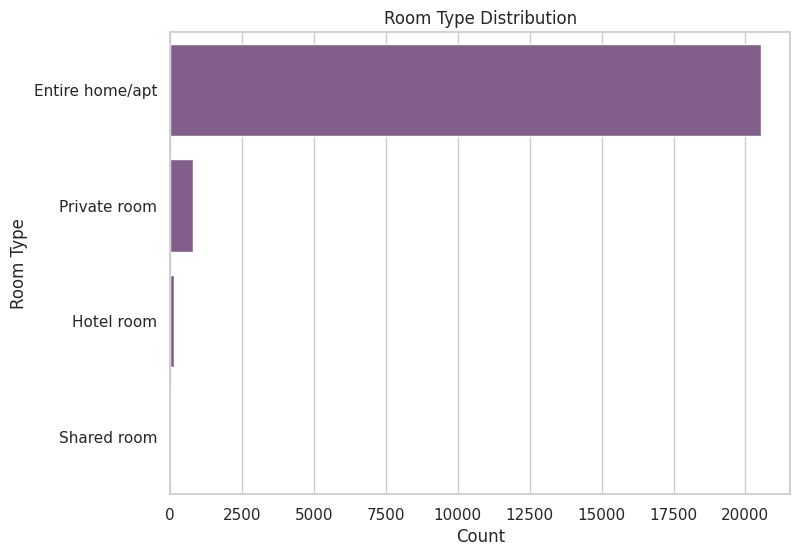

In [21]:
# Set the style for plot (seaborn)
sns.set(style="whitegrid")

# Create a horizontal bar plot for room_type
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='room_type', order=df['room_type'].value_counts().index, color='#875692')
plt.title('Room Type Distribution')
plt.xlabel('Count')
plt.ylabel('Room Type')
plt.show()

Σύμφωνα με το παραπάνω γράφημα, ο πιο συχνός τύπος room_type για το 2023 είναι το Entire home/apt.

#### **1.2** ####
 **Φτιάξτε γράφημα ή γραφήματα που δείχνουν την πορεία των τιμών για το διάστημα των 3 μηνών.**

Θα φτιαχτεί ένα γράφημα για την πορεία των τιμών για τους 3 μήνες μαζί.

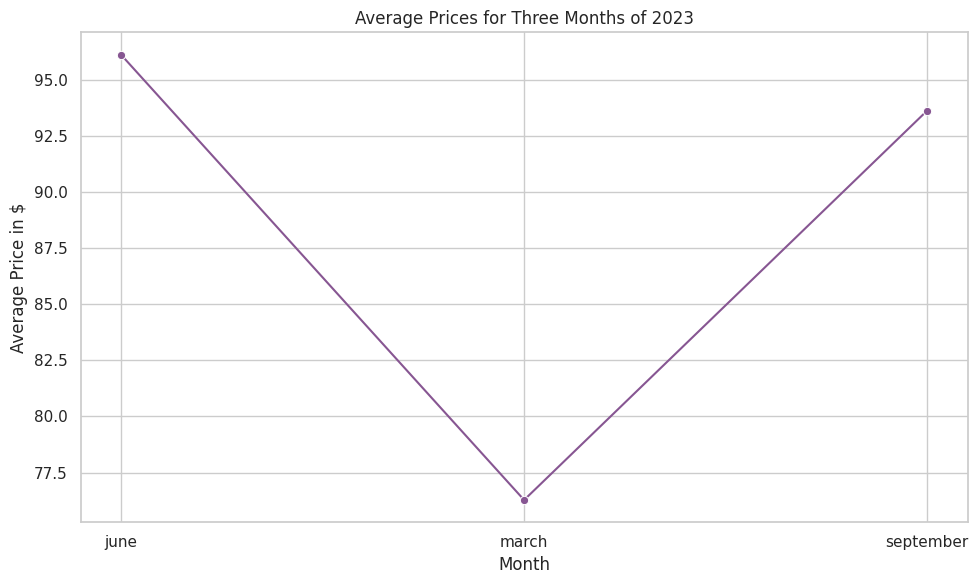

In [22]:
# Calculate the average price for each month
average_prices_2023 = df.groupby('month')['price'].mean().reset_index()

# Set seaborn
sns.set_style("whitegrid")

# Create plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_prices_2023, x='month', y='price', marker='o', color='#875692')

plt.title('Average Prices for Three Months of 2023')
plt.xlabel('Month')
plt.ylabel('Average Price in $')
plt.tight_layout()
plt.show()

Εδώ φαίνεται πως οι τιμές ήταν πιο αυξημένες τον μήνα Ιούνιο σε σχέση με τους μήνες Μάρτιο και Σεπτέμβριο, ενώ τον Μάρτιο ήταν οι χαμηλότερες για το έτος 2023.

#### **1.3** ####
 **Οι 5 πρώτες γειτονιές με τις περισσότερες κριτικές:**

In [23]:
# Get neighborhood and number of reviews columns
reviews23 = df[['neighbourhood_cleansed', 'number_of_reviews']]

# Sort in desceding order by number_of_reviews
reviews23 = reviews23.sort_values(by='number_of_reviews', ascending=False)

# We want unique neighborhood values 
reviews23 = reviews23.drop_duplicates(subset='neighbourhood_cleansed', keep='first')

# We want the first five neighborhoods
reviews23.head(5)

neighbourhood_cleansed  number_of_reviews
15887  ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ              328.0
275              ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              328.0
17145          ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ              328.0
8066                        ΕΛΛΗΝΟΡΩΣΩΝ              328.0
15479                       ΝΕΟΣ ΚΟΣΜΟΣ              328.0

#### **1.4** ####
**Η πρώτη γειτονιά σε καταχωρήσεις ακινήτων**

Σε αυτό το ερώτημα θα αφαιρέσουμε τα διπλότυπα Ids από το αρχείο μας, διότι έχουμε 3 ίδια Ids για κάθε ακίνητο (ένα για κάθε μήνα).

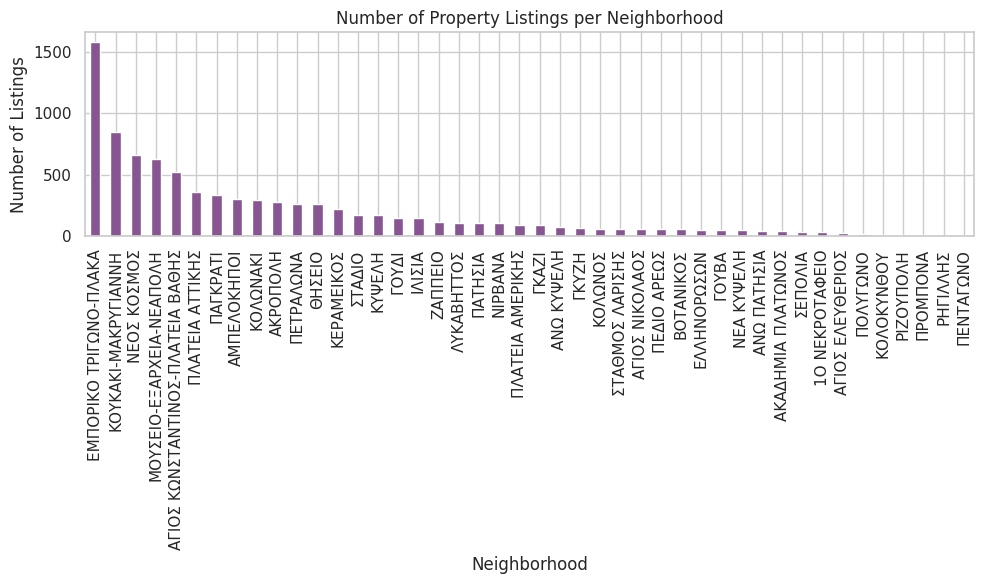

In [24]:
# Remove duplicate listings based on IDs (we don't want to count a property 3 times - one for each month)
unique_data = df.drop_duplicates(subset='id')

# Count the number of unique listings in each neighborhood
neighborhood_counts = unique_data['neighbourhood_cleansed'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
neighborhood_counts.plot(kind='bar', color='#875692')
plt.title('Number of Property Listings per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')

# Rotate x-axis labels to read them easier
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Παρατηρούμε ότι η γειτονία με τις περισσότερες καταχωρήσεις ακινήτων είναι το Εμπορικό Τρίγωνο-Πλάκα.

#### **1.5** ####
**Πόσες είναι οι καταχωρήσεις ανά γειτονιά και ανά μήνα;**

Σε αυτό το ερώτημα θα εμφανίσουμε τις καταχωρήσεις ανά γειτονία και ανά μήνα καθώς και ένα διάγραμμα που θα απεικονίζει το αποτέλεσμα αυτό.

    neighbourhood_cleansed      month  count
0           1Ο ΝΕΚΡΟΤΑΦΕΙΟ       june     25
1           1Ο ΝΕΚΡΟΤΑΦΕΙΟ      march     30
2           1Ο ΝΕΚΡΟΤΑΦΕΙΟ  september     28
3         ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ       june     18
4         ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ      march     21
..                     ...        ...    ...
127                 ΣΤΑΔΙΟ      march    135
128                 ΣΤΑΔΙΟ  september    134
129        ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ       june     53
130        ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ      march     52
131        ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ  september     51

[132 rows x 3 columns]


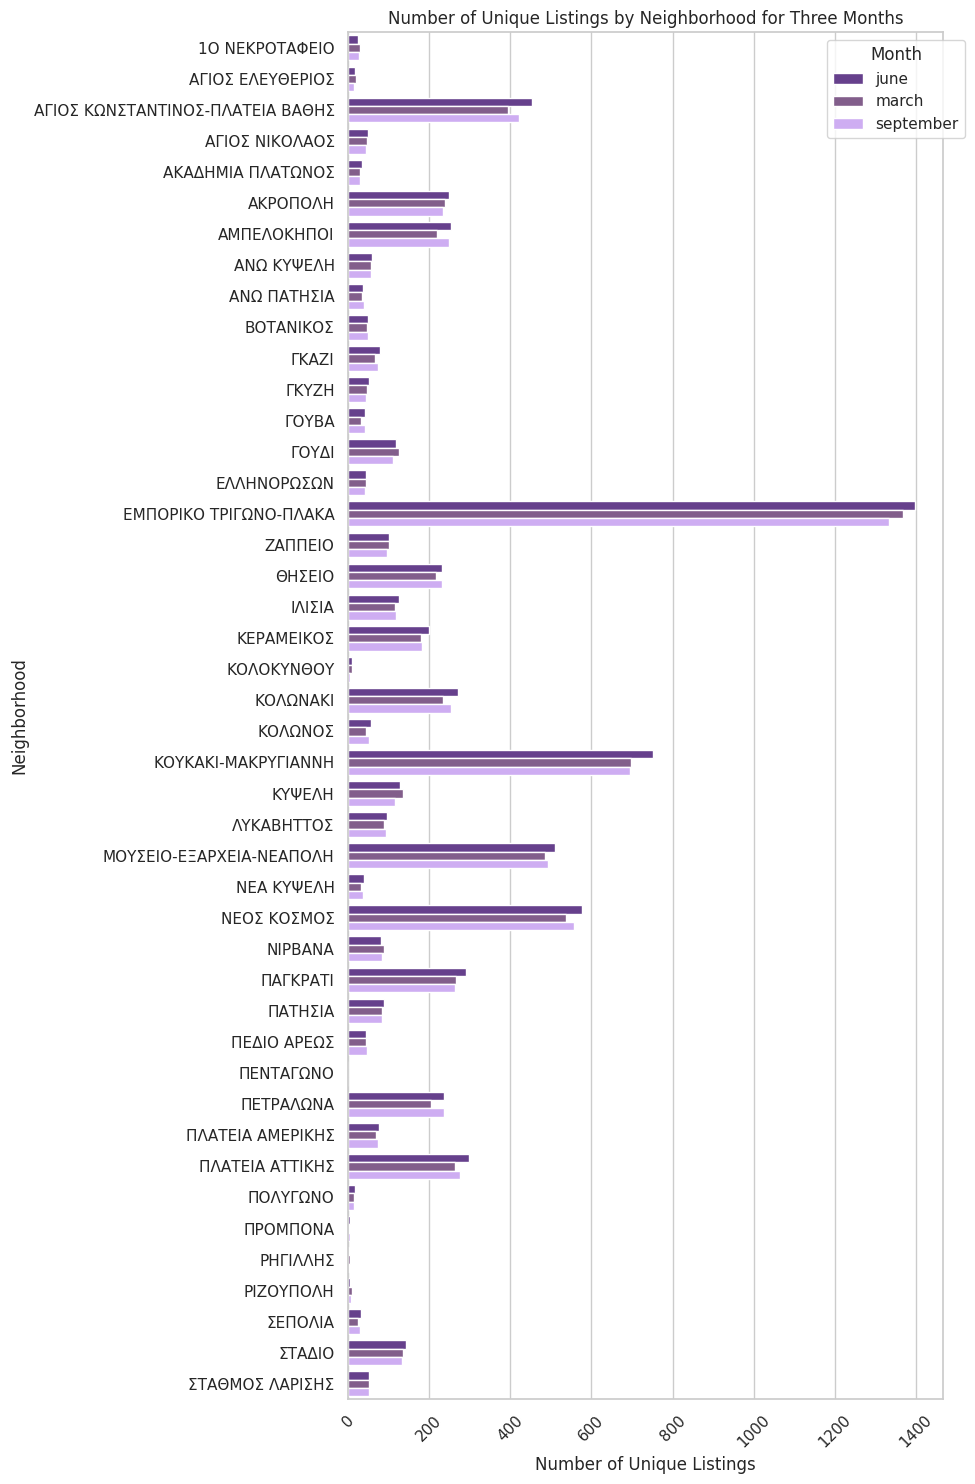

In [25]:
# Keep only the columns we want 
listings_df = df[['id', 'neighbourhood_cleansed', 'month']].copy()

# Group by neighborhood and month and count for each unique id 
listingscount = listings_df.groupby(['neighbourhood_cleansed', 'month'])['id'].nunique()

# Convert to DataFrame
listingscount_df = listingscount.reset_index(name='count')

# Print all the values
print(listingscount_df)

# Set Seaborn style
sns.set_style("whitegrid")

# Custom colors (shades of purple)
custom_palette = ["#663399", "#875692","#CEA2FD"]
sns.set_palette(custom_palette)

# Create a new figure and axis
plt.figure(figsize=(10, 15))

# Create the bar plot
sns.barplot(data=listingscount_df, x='count', y='neighbourhood_cleansed', hue='month')

# Set title and labels
plt.title('Number of Unique Listings by Neighborhood for Three Months')
plt.xlabel('Number of Unique Listings')
plt.ylabel('Neighborhood')
plt.xticks(rotation=45)

# Adjust legend
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='best')

plt.tight_layout()
plt.show()

#### **1.6** ####
**Σχεδιάστε το ιστόγραμμα της μεταβλητής neighborhood.**

Εδώ θα μετρήσουμε πόσο συχνά εμφανίζεται η κάθε γειτονιά μέσα στα δεδομένα μας

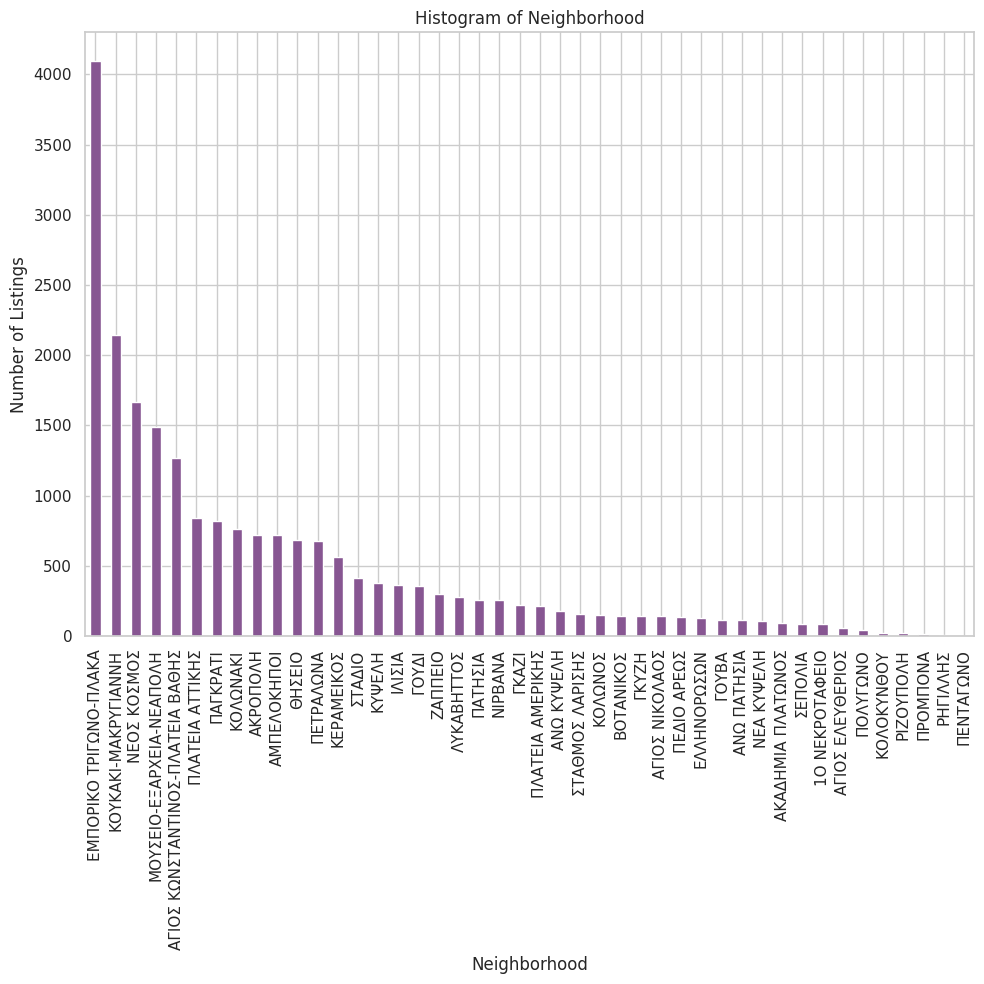

In [26]:
# Count the number of listings in each neighborhood
neighborhood_counts = df['neighbourhood_cleansed'].value_counts()

# Plot
plt.figure(figsize=(10, 10))
neighborhood_counts.plot(kind='bar', color='#875692')
plt.title('Histogram of Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')

# Rotate x-axis labels to read them easier
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### **1.7** #### 
**Ποιος είναι ο πιο συχνός τύπος δωματίου (room_type) σε κάθε γειτονιά (neighborhood);**

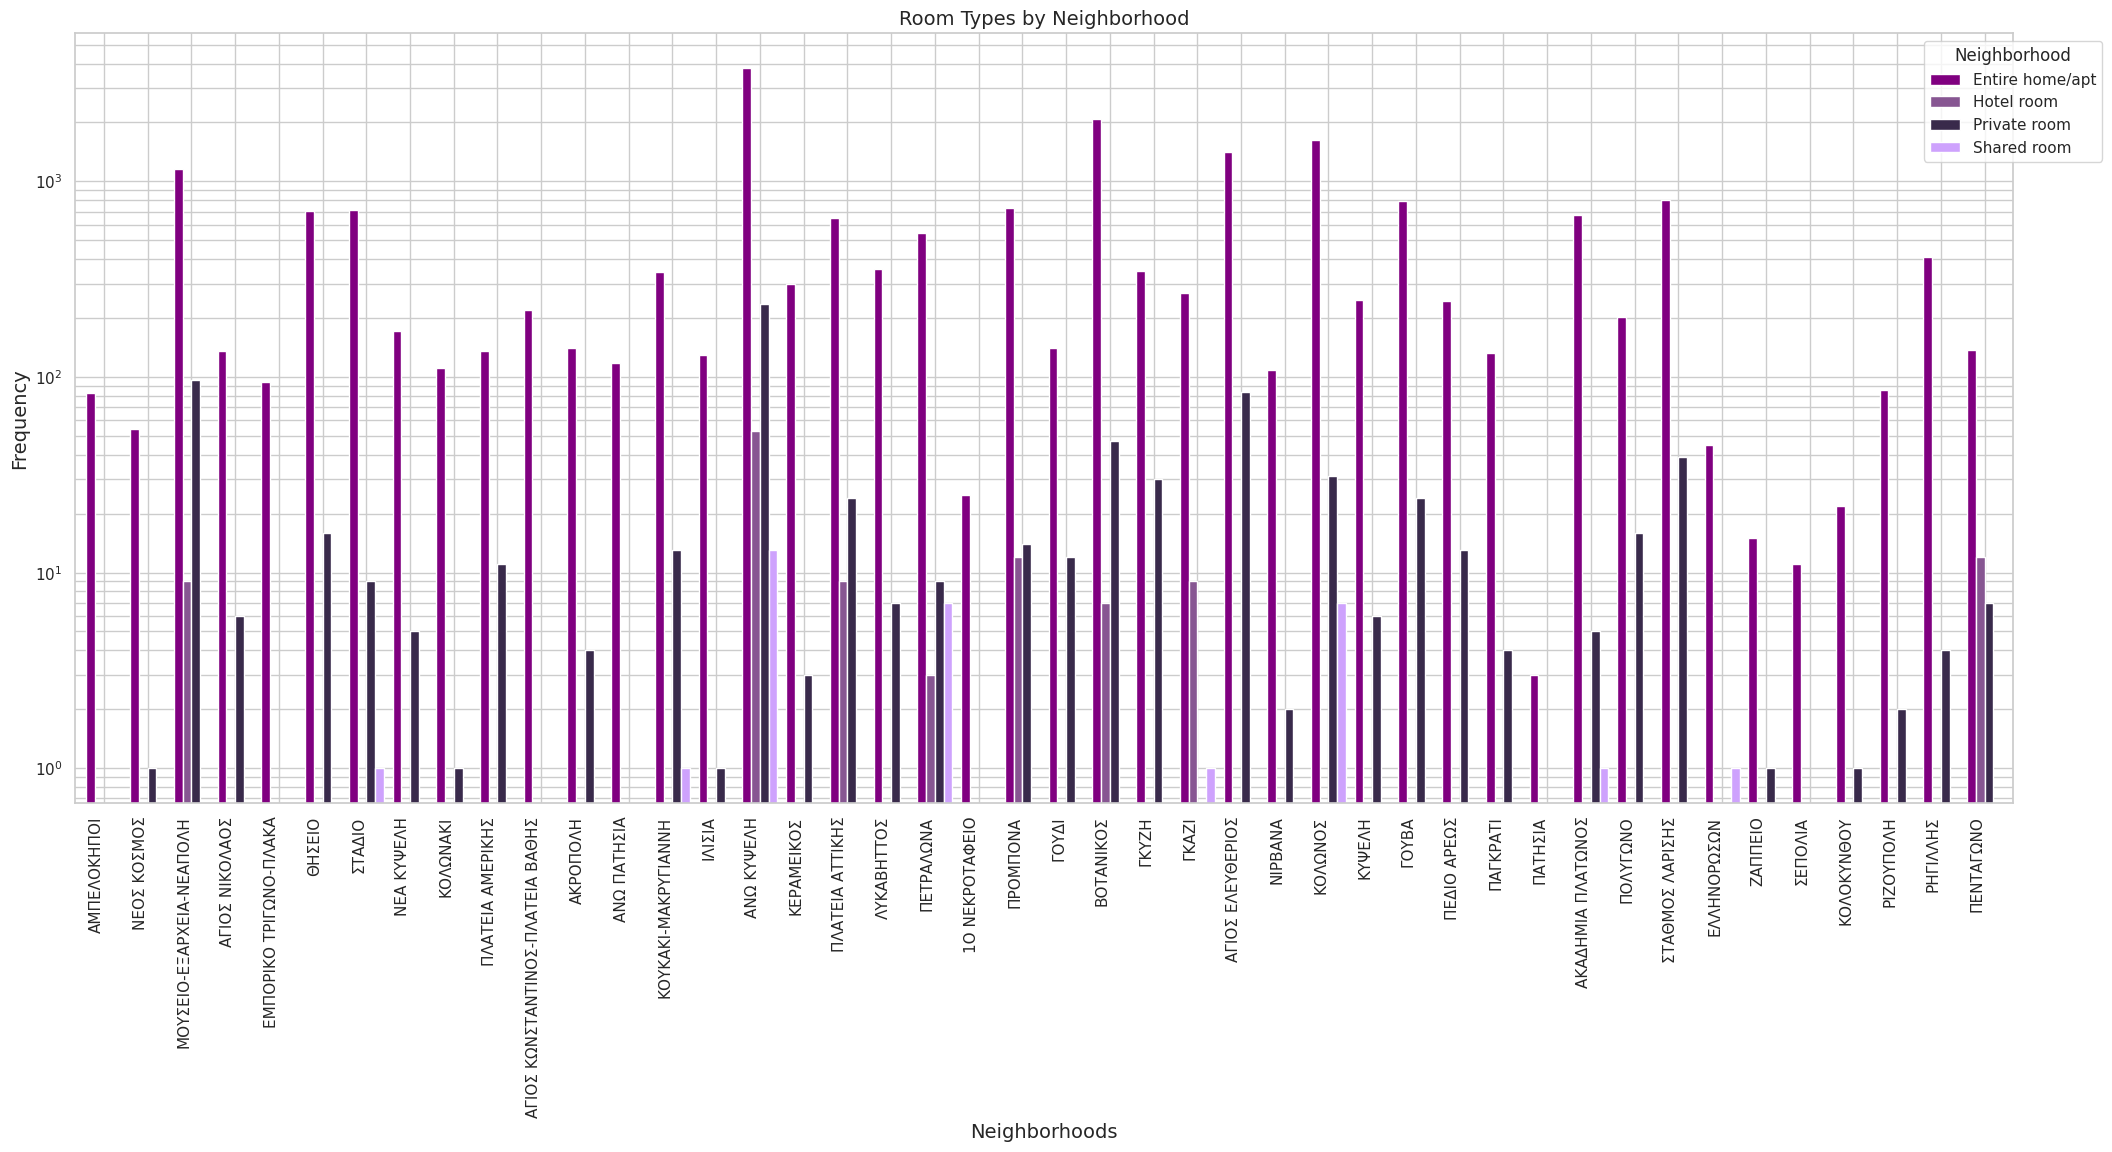

In [27]:
# Extract only unique neighborhood names
neighborhood_names = df['neighbourhood_cleansed'].unique()

# Group the data by neighbourhood and room type
grouped_data = df.groupby(['neighbourhood_cleansed','room_type']).size().unstack(fill_value=0)

# Set style
sns.set_style("whitegrid")

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(25, 10))  # Larger figure size with increased width

# Create a grouped bar chart
grouped_data.plot(kind='bar', stacked=False, width=0.8, ax=ax, color=['purple','#875692','#392A4B','#CEA2FD'])

# We use log in y-axis for better presentation of data
ax.set_yscale('log')
plt.grid(True, which="both", ls="-")
plt.title('Room Types by Neighborhood',fontsize=14)
plt.xlabel('Neighborhoods',fontsize=14)
plt.ylabel('Frequency',fontsize=14)

# Set custom x-axis ticks and labels
custom_ticks = range(len(neighborhood_names))
ax.set_xticks(custom_ticks)
ax.set_xticklabels(neighborhood_names)

plt.xticks(rotation=90, ha='right')
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

Σύμφωνα με το παραπάνω διάγραμμα φαίνεται πως ο πιο συχνός τύπος δωματίου σε κάθε γειτονία είναι ο Entire home/apt.

#### **1.8** ####
**Ποιός είναι ο πιο ακριβός τύπος δωματίου;**

Σε αυτό το ερώτημα θα κάνουμε σύγκριση σύμφωνα με τον μέσο όρο των τιμών για το κάθε room type.

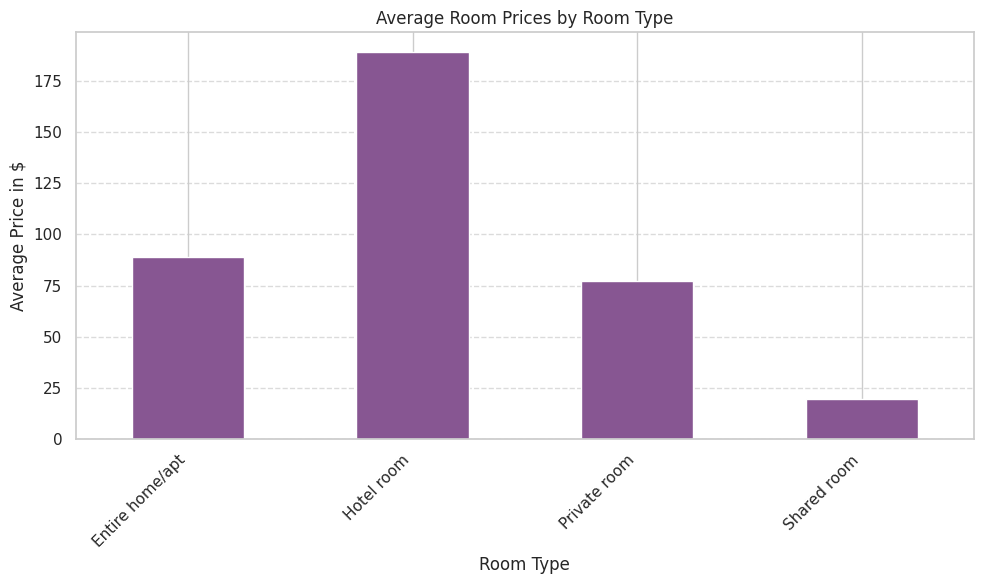

In [28]:
# Group the data by room type and calculate the mean price for each group
average_prices = df.groupby('room_type')['price'].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
average_prices.plot(kind='bar', color='#875692')
plt.title('Average Room Prices by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price in $')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Εδώ φαίνεται πως ο πιο αρκιβός τύπος δωματίου είναι το Hotel room για το 2023.

#### **1.9** ####
**Folium Map με τις στήλες latitude/longitude.**

Το ερώτημα αυτό απαντήθηκε παρακάτω για το έτος 2019.

#### **1.10** ####
 **Wordclouds για τις στήλες neighbourhood, transit, description, comments.**

Κρατάμε μόνο τα unique ids έτσι ώστε να μην μετρήσουμε κάποια πληροφορία 2η φορά για διαφορετικό μήνα.

Η στήλη comments αντιστοιχεί στα σχόλια που γράφτηκαν για τα reviews.  
(Για το 2023 δεν υπάρχει η στήλη transit, άρα δεν θα φτιαχτεί κάποιο wordcloud γι αυτή)

**Neighborhoods WC**

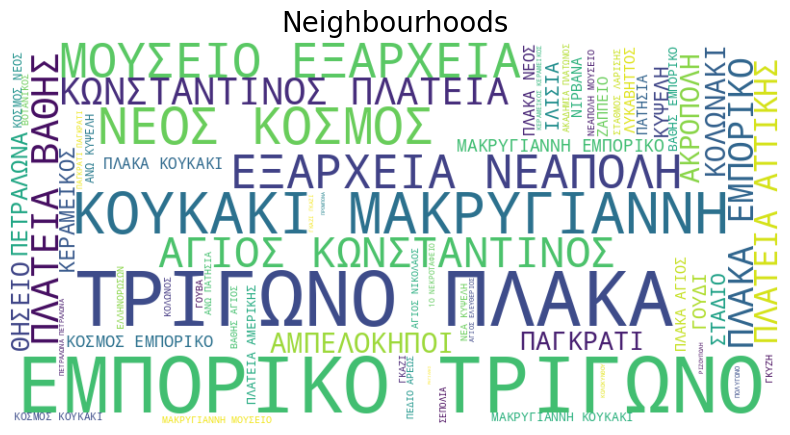

In [29]:
# Drop duplicates based on id 
uids_df = df.drop_duplicates(subset=['id'])

# Save all neigborhoods into a list 
neigborhoods = ' '.join(uids_df['neighbourhood_cleansed'].astype(str))

# Create the wordcloud for neighborhood
neighbwc = WordCloud(prefer_horizontal=0, width=800, height=400, background_color='white').generate(neigborhoods)

plt.figure(figsize=(10, 5))
plt.imshow(neighbwc, interpolation='bilinear')
plt.title('Neighbourhoods', fontsize=20, color='black')
plt.axis('off')
plt.show()

**Description WC** 

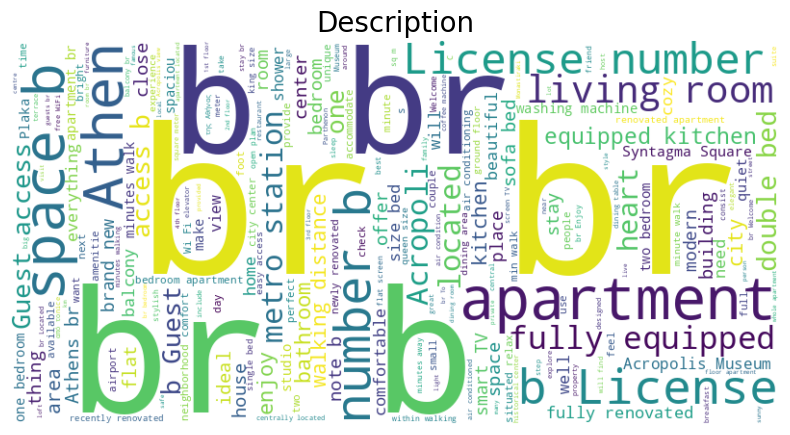

In [30]:
description = ' '.join(uids_df['description'].astype(str))

# Create the wordcloud for description
descriptionwc = WordCloud(prefer_horizontal=0, width=800, height=400, background_color='white').generate(description)

plt.figure(figsize=(10, 5))
plt.imshow(descriptionwc, interpolation='bilinear')
plt.title('Description', fontsize=20, color='black')
plt.axis('off')
plt.show()

**Comments WC** 

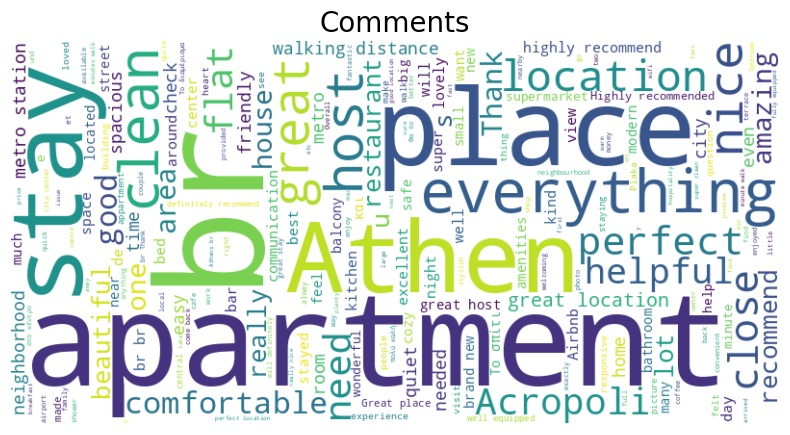

In [31]:
comments = ' '.join(uids_df['comments'].astype(str))

# Create the wordcloud for comments
commentswc = WordCloud(prefer_horizontal=0, width=800, height=400, background_color='white').generate(comments)

plt.figure(figsize=(10, 5))
plt.imshow(commentswc, interpolation='bilinear')
plt.title('Comments', fontsize=20, color='black')
plt.axis('off')
plt.show()

#### **1.11** ####
 **Amenities - απλοποίηση πληροφορίας**

Εκτύπωση μοναδικών τιμών

In [32]:
uniqueAm = df['amenities'].unique()

uniqueAm

array(['["Coffee maker", "Hot water", "Bed linens", "Ethernet connection", "High chair", "Pack \\u2019n play/Travel crib", "Hangers", "Central heating", "Extra pillows and blankets", "Self check-in", "Private patio or balcony", "Refrigerator", "Essentials", "Wifi", "Cooking basics", "Oven", "Dishwasher", "Shower gel", "Free street parking", "Single level home", "Shampoo", "43\\" HDTV", "Dishes and silverware", "Hair dryer", "Laundromat nearby", "Free washer \\u2013 In unit", "Crib", "Iron", "AC - split type ductless system", "Kitchen", "Microwave", "Electric stove", "Keypad"]',
       '["Coffee maker", "Hot water", "Bed linens", "Ethernet connection", "High chair", "Pack \\u2019n play/Travel crib", "Hangers", "Central heating", "Extra pillows and blankets", "Self check-in", "Private patio or balcony", "Refrigerator", "Essentials", "Cooking basics", "Oven", "Shower gel", "Free street parking", "Single level home", "Smart lock", "Shampoo", "43\\" HDTV", "Paid parking off premises", "Dish

Δημιουργούμε ένα dictionary με τις πιθανές τιμές και τη κατηγορία που εντάσσονται. Έχουμε ομαδοποιήσει τα δεδομένα σύμφωνα με τις κατηγορίες που προτείνονται στην εκφώνηση.

In [33]:
amenitiesMap = {
    "kitchen": ["Kitchen", "Dishwasher", "Microwave", "Oven", "Stove", "Refrigerator", "Coffee maker", "Cooking basics", "Dishes and silverware", "Dryer", "BBQ", "grill"],
    "accessibility": ["Elevator", "Wide doorway", "Step-free access", "Single level home"],
    "Electricity_and_Technology": ["TV", "Cable TV", "Internet", "Wifi", "Ethernet connection", "WIFI", "Tv", "Ethernet cable", "Ethernet"],
    "facilities": ["Air conditioning", "Heating", "Washer", "Dryer", "First aid kit", "Safety card", "Fire extinguisher", "Essentials", "Shampoo", "24-hour check-in", "Hangers", "Hair dryer", "Iron", "Laptop friendly workspace", "Hot water", "Bed linens", "Extra pillows and blankets"],
    "kids_friendly": ["Family/kid friendly", "High chair", "Pack ’n Play/travel crib"],
    "security": ["Smoke detector", "Carbon monoxide detector", "Lock on bedroom door"],
    "services": ["Private entrance", "Room-darkening shades", "Long term stays allowed", "Handheld shower head", "Well-lit path to entrance", "Host greets you"]
}

Αντικαθιστούμε τις τιμές σε ένα καινούριο dataframe, με όνομα **simple_am_df** και το εκτυπώνουμε.

In [34]:
simple_am_df = pd.DataFrame(columns=['amenities_simple'])

for index, row in df.iterrows():
    replaced_categories = set()     # Save the categories to replace one time per value 
    replaced_amenities = []         # Store replacements for the current row 
    for category, values in amenitiesMap.items():
        if any(value in row['amenities'] for value in values):
            if category not in replaced_categories:
                replaced_categories.add(category)
                replaced_amenities.append(category)
    simple_am_df.loc[index] = [', '.join(replaced_amenities)]  # Save to new df 

# Sorting 
simple_am_df['amenities_simple'] = simple_am_df['amenities_simple'].apply(lambda x: ', '.join(sorted(x.split(', '))))

with pd.option_context('display.max_colwidth', None):
    print(simple_am_df)

                                                                              amenities_simple
0                Electricity_and_Technology, accessibility, facilities, kids_friendly, kitchen
1                Electricity_and_Technology, accessibility, facilities, kids_friendly, kitchen
2      Electricity_and_Technology, accessibility, facilities, kids_friendly, kitchen, services
3      Electricity_and_Technology, accessibility, facilities, kids_friendly, kitchen, services
4                     Electricity_and_Technology, accessibility, facilities, kitchen, services
...                                                                                        ...
21459                 Electricity_and_Technology, accessibility, facilities, kitchen, services
21460                                Electricity_and_Technology, facilities, kitchen, services
21461                 Electricity_and_Technology, accessibility, facilities, kitchen, services
21462                                          Ele

Δημιουργούμε το ιστόγραμμα με τις νέες τιμές.

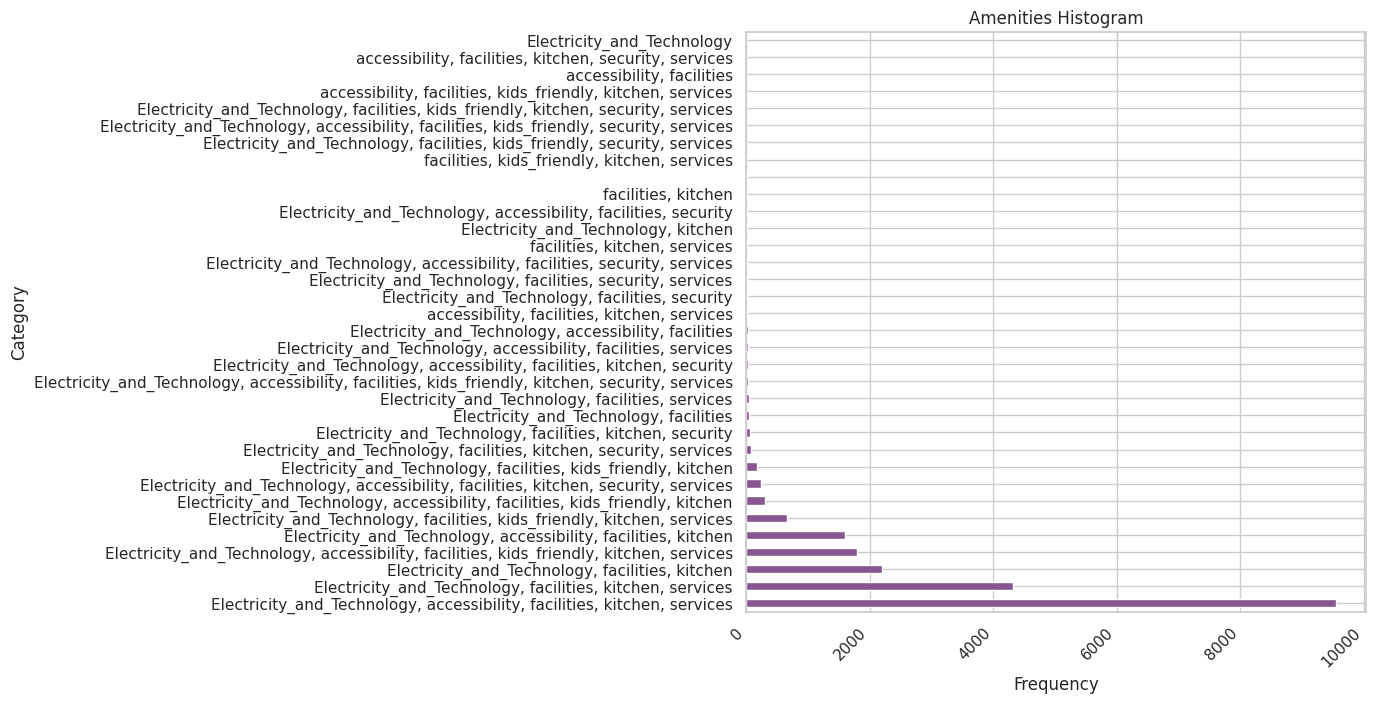

In [35]:
plt.figure(figsize=(8, 10))
simple_am_df['amenities_simple'].value_counts().plot(kind='barh', color='#875692')
plt.title('Amenities Histogram')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)  # Increase bottom margin

plt.show()

#### **1.12** ####

**Υπολογισμός μέσης τιμής ανά γειτονία (μόνο για δωμάτια που φιλοξενούν 2 άτομα) και κατάταξη σε 3 ομάδες (πολύ ακριβές, μέτριες, οικονομικές) ανάλογα με την μέση τιμή των δωματίων.**

Αρχικά θα υπολογίσουμε την μέση τιμή ανά γειτονία, θα τις ταξινομήσουμε σε φθίνουσα σειρά και θα εμφανίσουμε το ζητούμενο γράφημα.

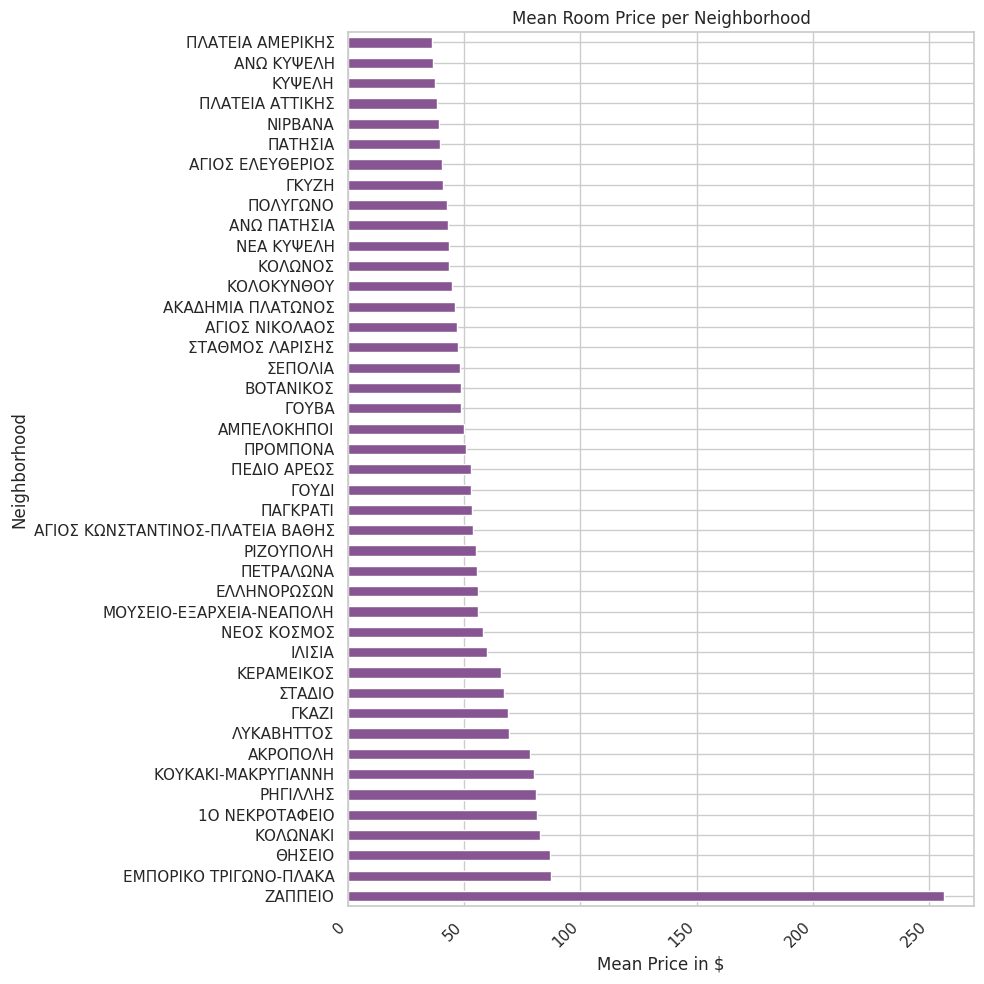

In [36]:
# Calculate the mean price per neighborhood for rooms that accommodate two people
mean_prices = df[df['accommodates'] == 2].groupby('neighbourhood_cleansed')['price'].mean()

# Sort neighborhoods by their mean price in descending order
mean_prices_sorted = mean_prices.sort_values(ascending=False)

# Display neighborhoods in a bar plot
plt.figure(figsize=(10, 10))
mean_prices_sorted.plot(kind='barh', color='#875692')
plt.title('Mean Room Price per Neighborhood')
plt.xlabel('Mean Price in $')
plt.ylabel('Neighborhood')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Στη συνέχεια θα κατατάξουμε τις περιοχές σε 3 κατηγορίες (πολύ ακριβές, μέτριες, οικονομικές) ανάλογα με την μέση τιμή των δωματίων και θα φτιάξουμε γράφημα για την κάθε κατηγορία.

In [37]:
price_bins = pd.cut(mean_prices,bins=[0, 50, 250, float('inf')], labels=['Οικονομικές', 'Μέτριες', 'Πολύ Ακριβές'])

# Create three separate DataFrames for each category
economy_neighborhoods = mean_prices[price_bins == 'Οικονομικές']
ok_neighborhoods = mean_prices[price_bins == 'Μέτριες']
expensive_neighborhoods = mean_prices[price_bins == 'Πολύ Ακριβές']

Γράφημα για τις 'Οικονομικές' περιοχές:

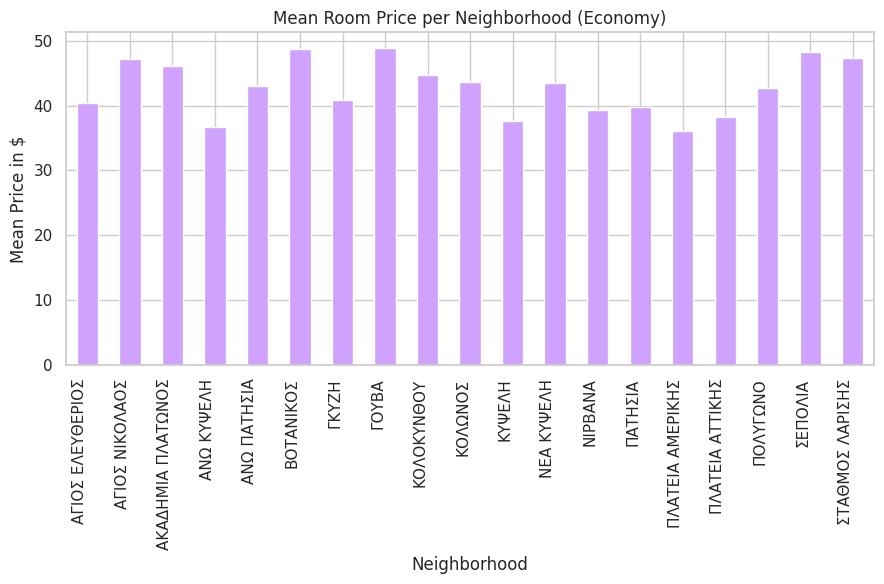

In [38]:
plt.figure(figsize=(9, 6))
economy_neighborhoods.plot(kind='bar', color='#CEA2FD')
plt.title('Mean Room Price per Neighborhood (Economy)')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price in $')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

Γράφημα για τις 'Μέτριες' περιοχές:

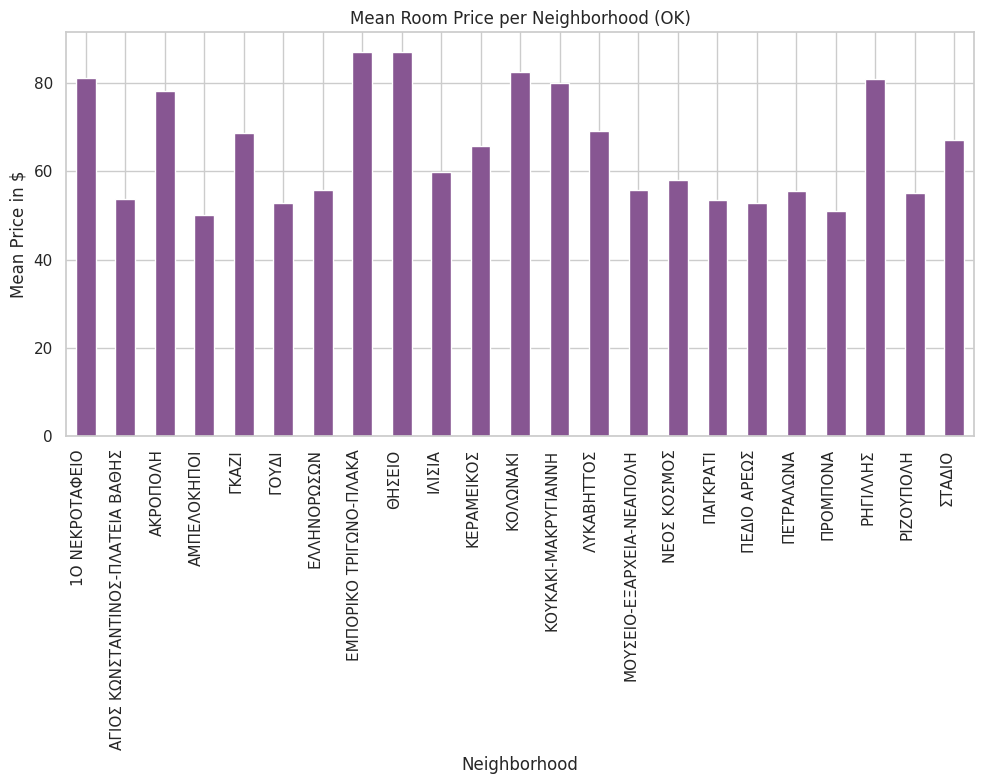

In [39]:
plt.figure(figsize=(10, 8))
ok_neighborhoods.plot(kind='bar', color='#875692')
plt.title('Mean Room Price per Neighborhood (ΟΚ)')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price in $')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

Γράφημα για τις 'Ακριβές' περιοχές:

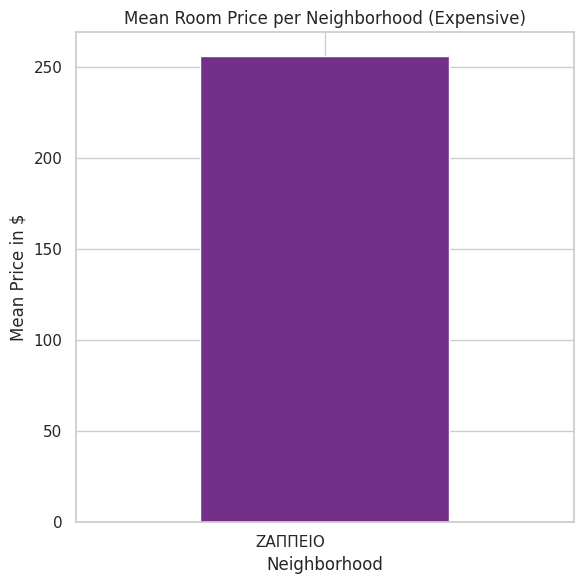

In [40]:
plt.figure(figsize=(6, 6))
expensive_neighborhoods.plot(kind='bar', color='#743089')
plt.title('Mean Room Price per Neighborhood (Expensive)')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price in $')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

#### **1.13** ####

**Δημιουργία 3 επιπλέον ερωτήσεων για την περιοχή της Αθήνας.**

**1. Ποιό ποσοστό των hosts που έχουν φωτογραφία προφίλ.**

(σε αυτό το ερώτημα θα χρησιμοποιήσουμε pie chart καθώς και την στήλη host_has_profile_pic από το ```train_2023.csv```)

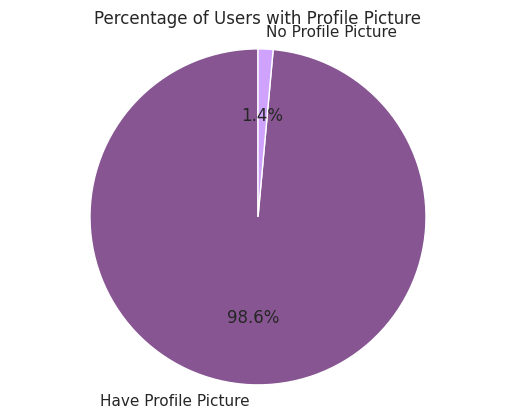

In [41]:
# Count how many times we have the value 't' (true) or 'f' (false) for hosts' profile pics
num_true = df[df['host_has_profile_pic'] == 't'].shape[0]
num_false = df[df['host_has_profile_pic'] == 'f'].shape[0]

# Create a list with the percentages and labels
labels = ['Have Profile Picture', 'No Profile Picture']
sizes = [num_true, num_false]
colors = ['#875692','#CEA2FD']  

# Create a pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

# Set title for the chart
plt.title('Percentage of Users with Profile Picture')

# Show the chart
plt.show()

**2. Ποιό είναι το ποσοστό των κρατήσεων για kids friendly καταλύματα για το έτος 2023;**

Σε αυτό το ερώτημα θα χρησιμοποιήσουμε το απλοποιημένο DataFrame που δημιουργήσαμε στο ερώτημα 1.11 για να βρούμε το ζητούμενο.  
(θα χρησιμοποιήσουμε pie chart για την αναπαράσταση)

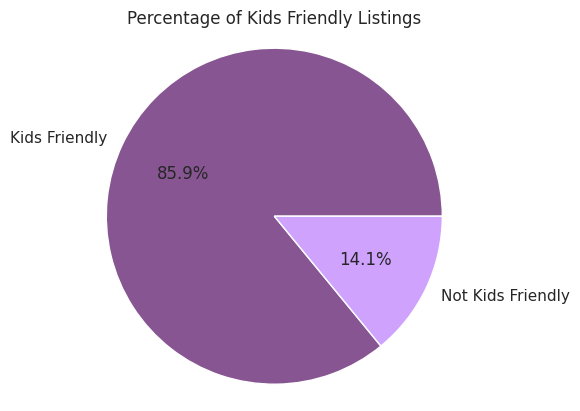

In [42]:
# Count how many times we have the word 'kids_friendly' in each row
simple_am_df['has_kids_friendly'] = simple_am_df['amenities_simple'].str.contains('kids_friendly')

# Count the number of rows with and without 'kids_friendly'
kids_friendly_counts = simple_am_df['has_kids_friendly'].value_counts()

# Create a pie chart
labels = ['Kids Friendly', 'Not Kids Friendly']
plt.pie(kids_friendly_counts, labels=labels, autopct='%1.1f%%', colors=['#875692','#CEA2FD'])
plt.title('Percentage of Kids Friendly Listings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

**3. Ποιός είναι ο πιο συχνός τύπος property_type;**

Εδώ θα αξιοποιήσουμε την στήλη property_type.

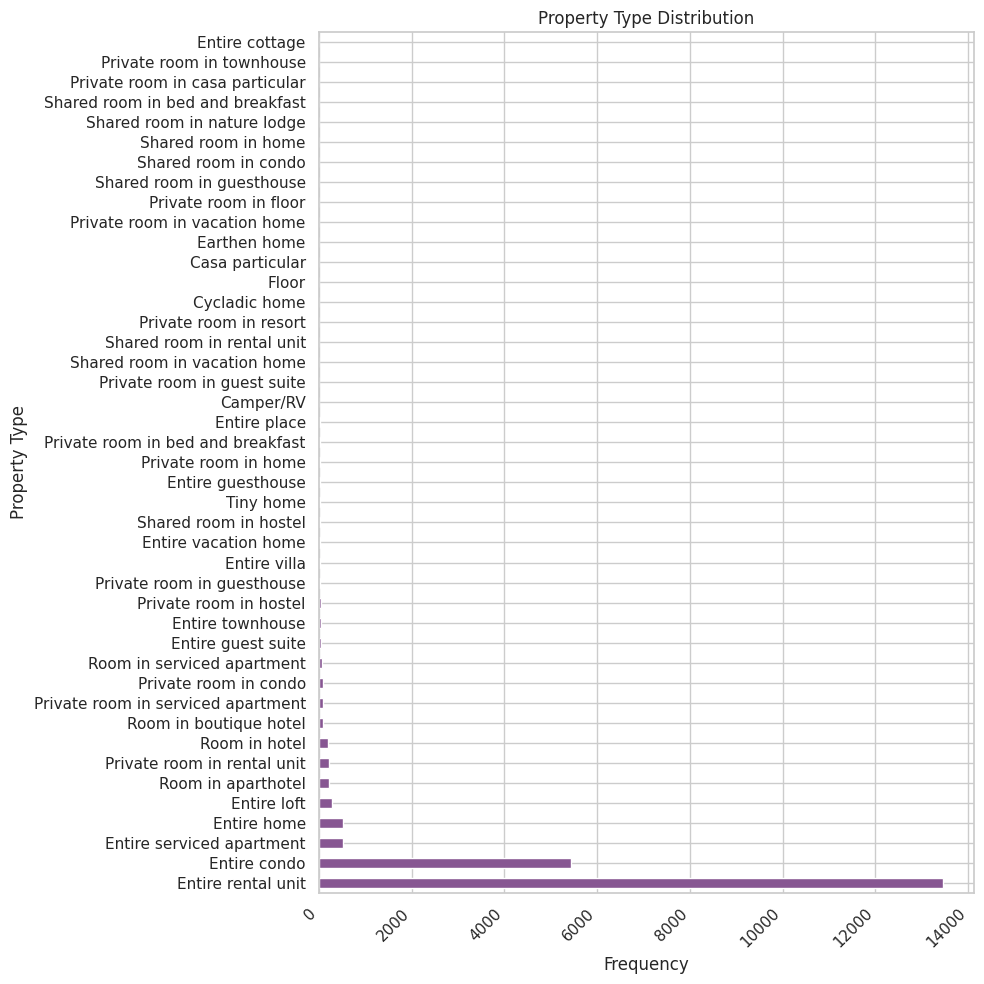

In [43]:
# Count the frequency of each property type
property_type_counts = df['property_type'].value_counts()

# Set the figure size
plt.figure(figsize=(10, 10))

# Create the plot
property_type_counts.plot(kind='barh', color='#875692')
plt.title('Property Type Distribution')
plt.xlabel('Frequency')
plt.ylabel('Property Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()                  # Adjust layout to fit better in the window
plt.show()

Εδώ φαίνεται πως ο πιο συχνός τύπος property_type είναι ο Entire rental unit.

#### **1.14** ####

**Οι 10 πρώτοι hosts με τα περισσότερα ακίνητα.**

In [44]:
# Create a new df with the columns id and host_id
unique_listingsdf = df[['id', 'host_id']]

# Keep unique combinations of host_id and id 
unique_listingsdf = unique_listingsdf.drop_duplicates(subset=['host_id', 'id'])

# Group by host_id and count the number of listings 
host_listingsdf = unique_listingsdf.groupby('host_id').size().reset_index(name='hlistings_count')

# Sort in descending order by hlistings
host_listingsdf = host_listingsdf.sort_values(by='hlistings_count', ascending=False)

# Create the new df
host_listings_count = host_listingsdf[['host_id', 'hlistings_count']]

# We want the first ten
host_listings_count.head(10)

host_id  hlistings_count
459    20104194.0               96
1331   90390850.0               66
46       748818.0               65
634    29927830.0               58
1512  113548208.0               53
2087  182156346.0               46
96      2089542.0               45
1510  113353393.0               42
1576  123074489.0               42
1504  112527018.0               39

> ### Ανάλυση Δεδομένων για το έτος 2019 ###

Διαβάζουμε το αρχείο το οποίο θέλουμε να αναλύσουμε.

In [45]:
# Read the file we need to analyze
df = pd.read_csv('train_2019.csv')

#### **1.1** #### 
**Ποιός είναι ο πιο συχνός τύπος room_type για τα δεδομένα σας;**

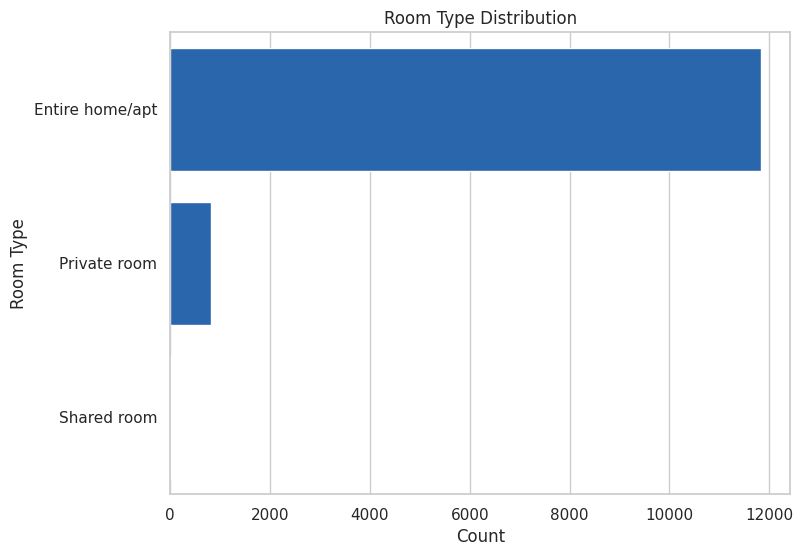

In [46]:
# Set the style for plot (seaborn)
sns.set(style="whitegrid")

# Create a horizontal bar plot for room_type
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='room_type', order=df['room_type'].value_counts().index, color='#1565C0')
plt.title('Room Type Distribution')
plt.xlabel('Count')
plt.ylabel('Room Type')
plt.show()

Παρατηρούμε πως και για το έτος 2019 ο πιο συχνός τύπος room_type είναι το Entire home/apt.

#### **1.2** ####
 **Φτιάξτε γράφημα ή γραφήματα που δείχνουν την πορεία των τιμών για το διάστημα των 3 μηνών.**

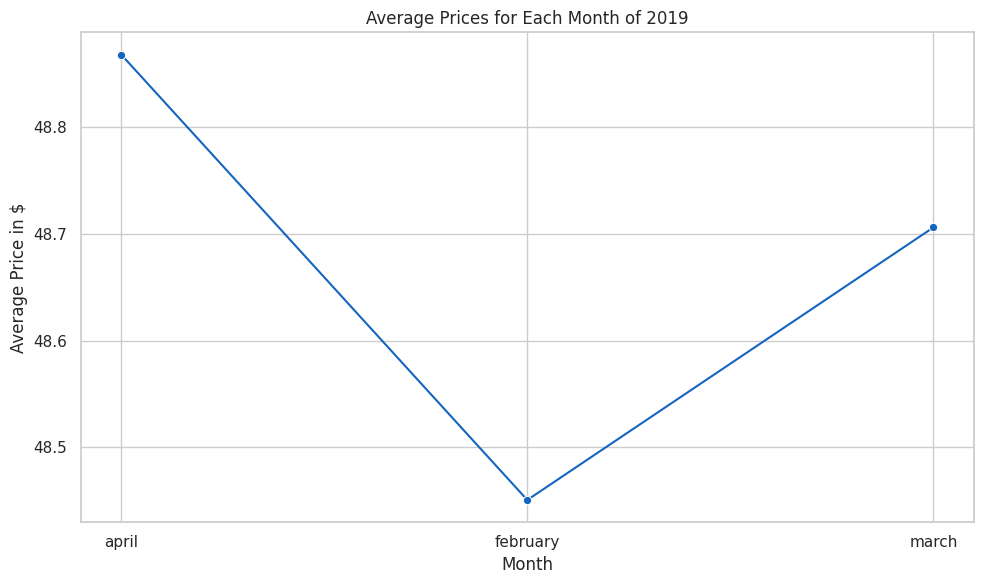

In [47]:
# Calculate the average price for each month
average_prices_2019 = df.groupby('month')['price'].mean().reset_index()

# Set seaborn
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_prices_2019, x='month', y='price', marker='o', color='#1565C0')

plt.title('Average Prices for Each Month of 2019')
plt.xlabel('Month')
plt.ylabel('Average Price in $')
plt.tight_layout()
plt.show()

Παρατηρούμε πως οι τιμές ήταν χαμηλότερες τον μήνα Φεβρουάριο και υψηλότερες τον μήνα Απρίλιο. Τον μήνα Μάρτιο οι τιμές ήταν περίπου στη μέση σε σχέση με τους άλλους 2 μήνες.

#### **1.3** ####
 **Οι 5 πρώτες γειτονιές με τις περισσότερες κριτικές:**

In [48]:
# Get neighborhood and number of reviews columns
reviews19 = df[['neighbourhood', 'number_of_reviews']]

# Sort in desceding order by number_of_reviews
reviews19 = reviews19.sort_values(by='number_of_reviews', ascending=False)

# We want unique neighborhood values 
reviews19 = reviews19.drop_duplicates(subset='neighbourhood', keep='first')

# We want the first five neighborhoods
reviews19.head(5)

neighbourhood  number_of_reviews
5130              Plaka                234
1034  Akadimia Platonos                234
8563               Mets                234
8653       Metaxourgeio                233
8872              Psyri                231

#### **1.4** ####
**Η πρώτη γειτονιά σε καταχωρήσεις ακινήτων**

Σε αυτό το ερώτημα θα αφαιρέσουμε τα διπλότυπα Ids από το αρχείο μας, διότι έχουμε 3 ίδια Ids για κάθε ακίνητο (ένα για κάθε μήνα).

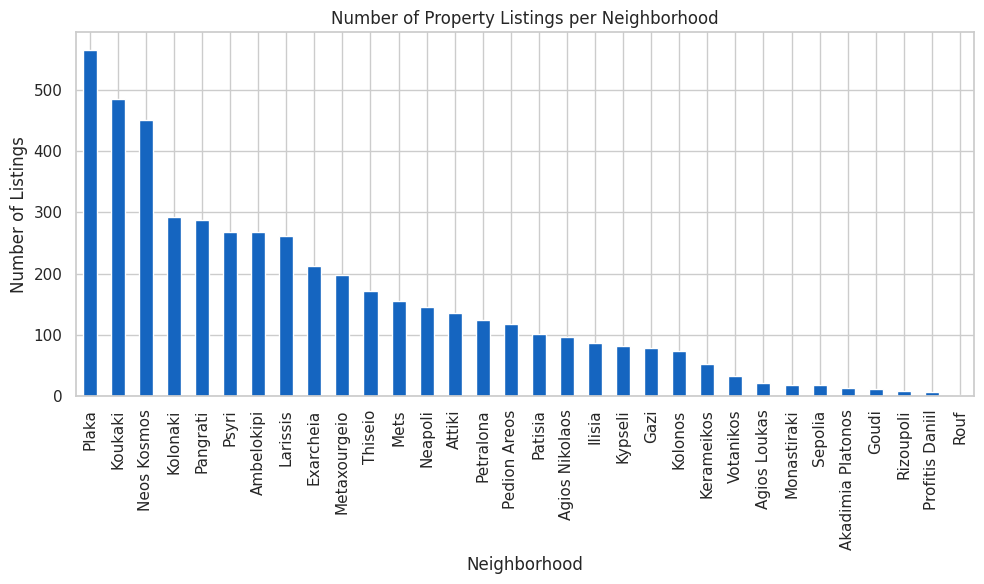

In [49]:
# Remove duplicate listings based on property IDs (we don't want to count a property 3 times - one for each month)
unique_data = df.drop_duplicates(subset='id')

# Count the number of unique listings in each neighborhood
neighborhood_counts = unique_data['neighbourhood'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
neighborhood_counts.plot(kind='bar', color='#1565C0')
plt.title('Number of Property Listings per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')

# Rotate x-axis labels to be easier to read them
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Παρατηρούμε ότι η Πλάκα είναι η γειτονιά με τις περισσότερες καταχωρήσεις ακινήτων.

#### **1.5** ####
**Πόσες είναι οι καταχωρήσεις ανά γειτονιά και ανά μήνα;**

Σε αυτό το ερώτημα θα εμφανίσουμε τις καταχωρήσεις ανά γειτονία και ανά μήνα καθώς και ένα διάγραμμα που θα απεικονίζει το αποτέλεσμα αυτό.

     neighbourhood     month  count
0     Agios Loukas     april     18
1     Agios Loukas  february     17
2     Agios Loukas     march     18
3   Agios Nikolaos     april     93
4   Agios Nikolaos  february     74
..             ...       ...    ...
91         Thiseio  february    152
92         Thiseio     march     43
93       Votanikos     april     32
94       Votanikos  february     26
95       Votanikos     march     29

[96 rows x 3 columns]


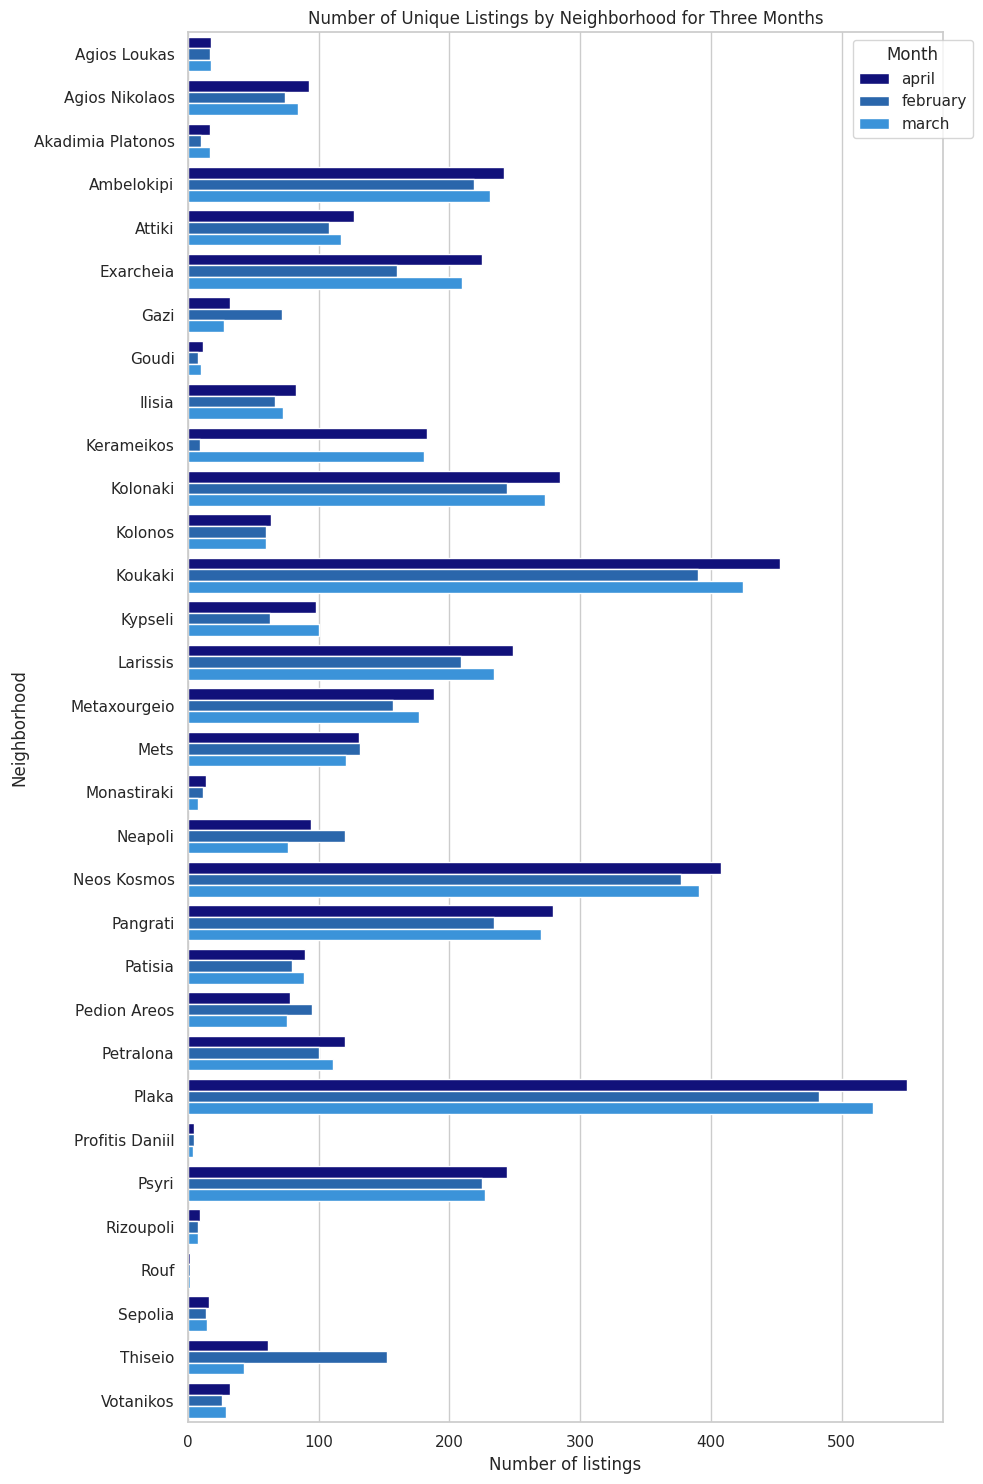

In [50]:
# Keep only the columns we want 
listings_df = df[['id', 'neighbourhood', 'month']].copy()

# Group by neighborhood and month and count for each unique id 
listingscount = listings_df.groupby(['neighbourhood', 'month'])['id'].nunique()

# Convert to DataFrame
listingscount_df = listingscount.reset_index(name='count')

# Print all the values
print(listingscount_df)

# Set Seaborn style
sns.set_style("whitegrid")

# Custom colors (shades of blue)
custom_palette = ["#00008B", "#1565C0","#2196F3"]
sns.set_palette(custom_palette)

plt.figure(figsize=(10, 15))

# Create the bar plot
sns.barplot(data=listingscount_df, x='count', y='neighbourhood', hue='month')

# Set title and labels
plt.title('Number of Unique Listings by Neighborhood for Three Months')
plt.xlabel('Number of listings')
plt.ylabel('Neighborhood')
plt.xticks(rotation=0)

# Adjust legend
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='best')

plt.tight_layout()
plt.show()

#### **1.6** ####
**Σχεδιάστε το ιστόγραμμα της μεταβλητής neighborhood.**

Εδώ θα μετρήσουμε πόσο συχνά εμφανίζεται η κάθε γειτονιά μέσα στα δεδομένα μας

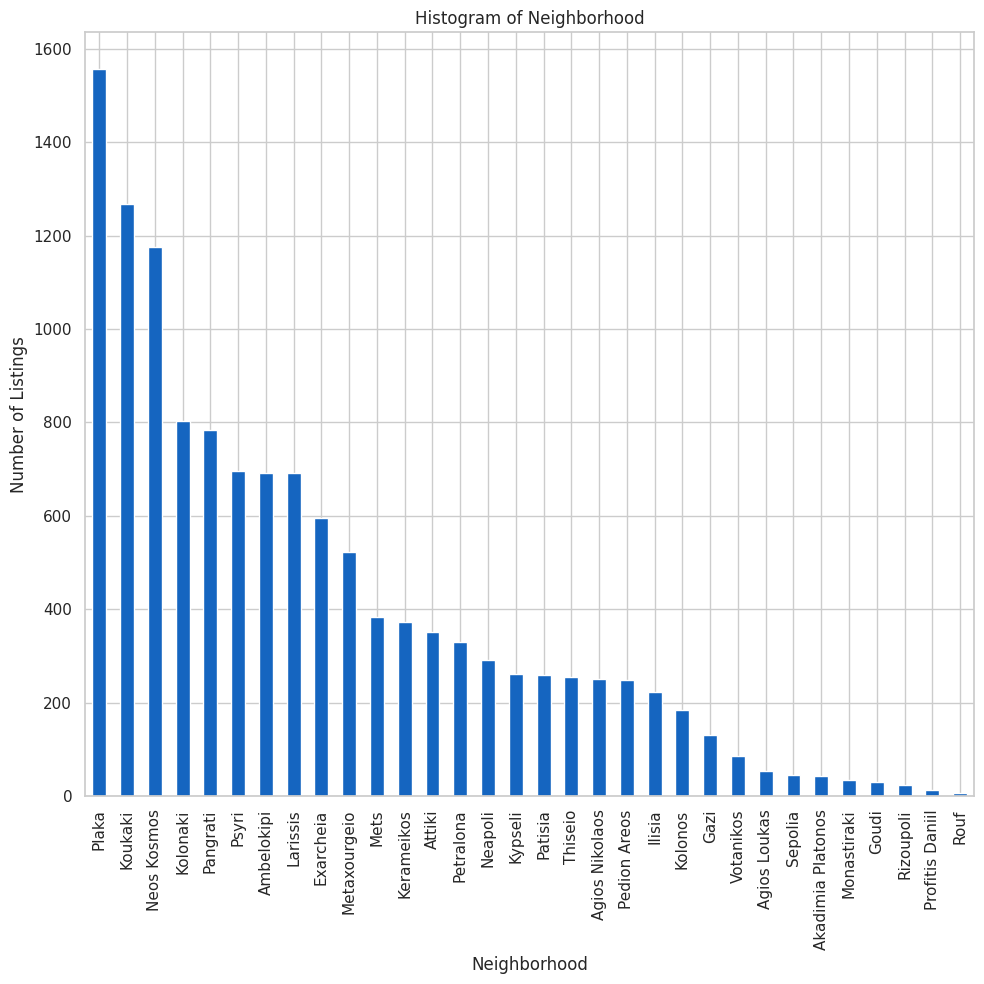

In [51]:
# Count the number of listings in each neighborhood
neighborhood_counts = df['neighbourhood'].value_counts()

# Plot
plt.figure(figsize=(10, 10))
neighborhood_counts.plot(kind='bar', color='#1565C0')
plt.title('Histogram of Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')

# Rotate x-axis labels to read them easier
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### **1.7** #### 
**Ποιος είναι ο πιο συχνός τύπος δωματίου (room_type) σε κάθε γειτονιά (neighborhood);**

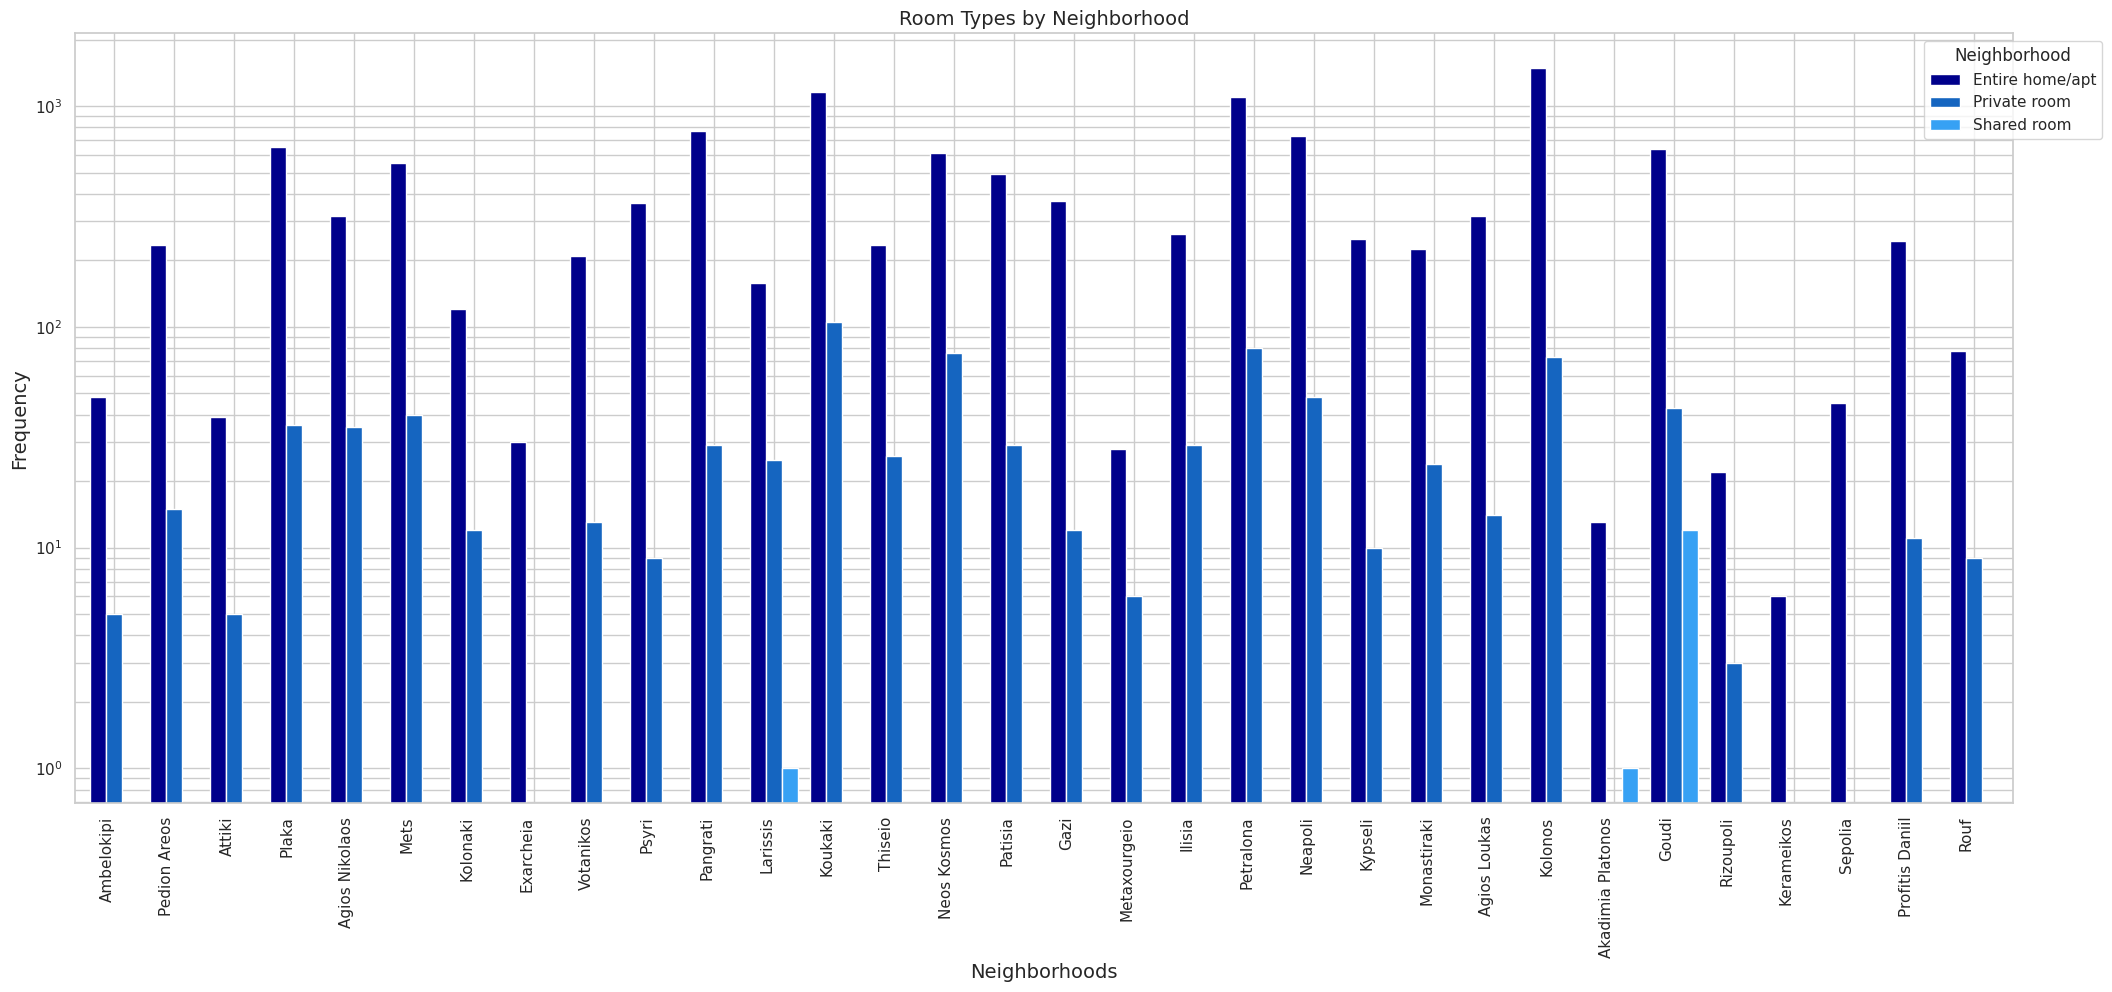

In [52]:
# Extract only unique neighborhood names
neighborhood_names = df['neighbourhood'].unique()

# Group the data by neighbourhood and room type
grouped_data = df.groupby(['neighbourhood','room_type']).size().unstack(fill_value=0)

# Set style
sns.set_style("whitegrid")

# Create a large figure for the many neighborhood names
fig, ax = plt.subplots(figsize=(25, 10))

# Create a bar chart
grouped_data.plot(kind='bar', stacked=False, width=0.8, ax=ax, color=['#00008B','#1565C0','#37A1F4'])

# We use log in y-axis for better presentation of data
ax.set_yscale('log')
plt.grid(True, which="both", ls="-")
plt.title('Room Types by Neighborhood',fontsize=14)
plt.xlabel('Neighborhoods',fontsize=14)
plt.ylabel('Frequency',fontsize=14)

# Set custom x-axis ticks and labels
custom_ticks = range(len(neighborhood_names))
ax.set_xticks(custom_ticks)
ax.set_xticklabels(neighborhood_names)

plt.xticks(rotation=90, ha='right')
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

Σύμφωνα με το παραπάνω διάγραμμα φαίνεται πως ο πιο συχνός τύπος δωματίου σε κάθε γειτονία είναι ο Entire home/apt.

#### **1.8** ####
**Ποιός είναι ο πιο ακριβός τύπος δωματίου;**

Σε αυτό το ερώτημα θα κάνουμε σύγκριση σύμφωνα με τον μέσο όρο των τιμών για το κάθε room type.

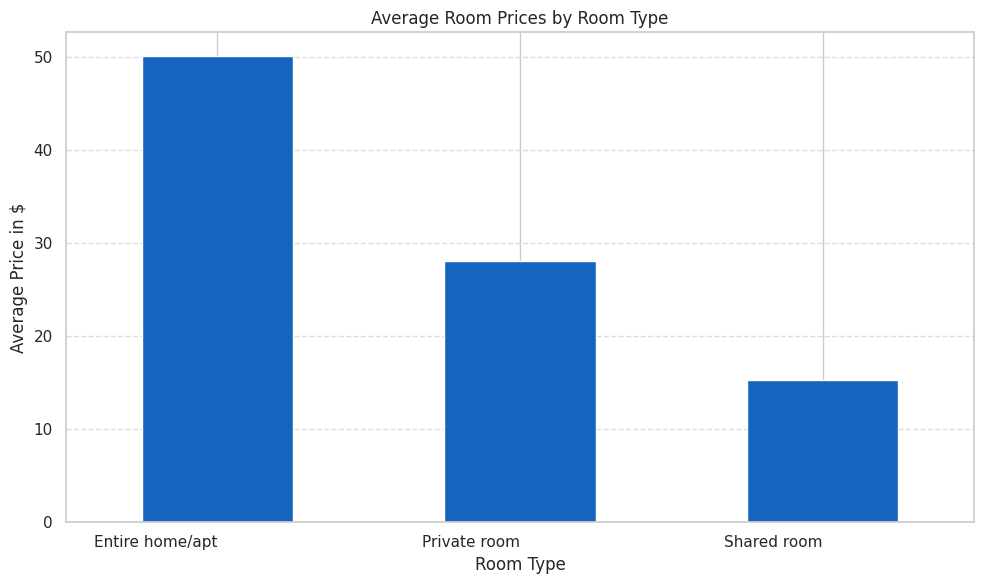

In [53]:
# Group the data by room type and calculate the mean price for each group
average_prices = df.groupby('room_type')['price'].mean()

# Create the bar plot
plt.figure(figsize=(10, 6))
average_prices.plot(kind='bar', color='#1565C0')
plt.title('Average Room Prices by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price in $')
plt.xticks(rotation=0, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Εδώ φαίνεται πως το Entire home/apt είναι ο πιο ακριβός τύπος δωματίου για το 2019.

#### **1.9** ####
 **Μόνο για το έτος 2019**

**Χάρτης με τα ακίνητα για το μήνα Απρίλιο. Η πληροφορία που εμφανίζεται για το ακίνητο είναι το room_type**

Εδώ θα κρατήσουμε 400 τυχαίες γραμμές από το DataFrame (400 τυχαία ακίνητα) τα οποία θα εμφανιστούν στον χάρτη.  
(Κάθε φορά θα επιλέγονται 400 διαφορετικά ακίνητα να εμφανίζονται και έτσι ο χάρτης δεν θα είναι πάντα ο ίδιος)

In [54]:
# Keep only the columns we want from our df 
month = 'april'
locations_df = df[["latitude", "longitude","month", "room_type"]]

# Keep only data for april
locations_df = locations_df[locations_df['month'] == month]

# Keep 400 random rows
locations_df = locations_df.sample(n=400)

# Create the map 
map = folium.Map(location=[locations_df.latitude.mean(), locations_df.longitude.mean()], zoom_start=14, control_scale=True)

# Adding points with "room_type" as a pop-up
for index, location in locations_df.iterrows():
    folium.Marker([location["latitude"], location["longitude"]], popup=location["room_type"]).add_to(map)

map

#### **1.10** ####
 **Wordclouds για τις στήλες neighbourhood, transit, description, comments.**

Κρατάμε μόνο τα unique ids έτσι ώστε να μην μετρήσουμε κάποια πληροφορία 2η φορά για διαφορετικό μήνα



**Neighborhoods WC**

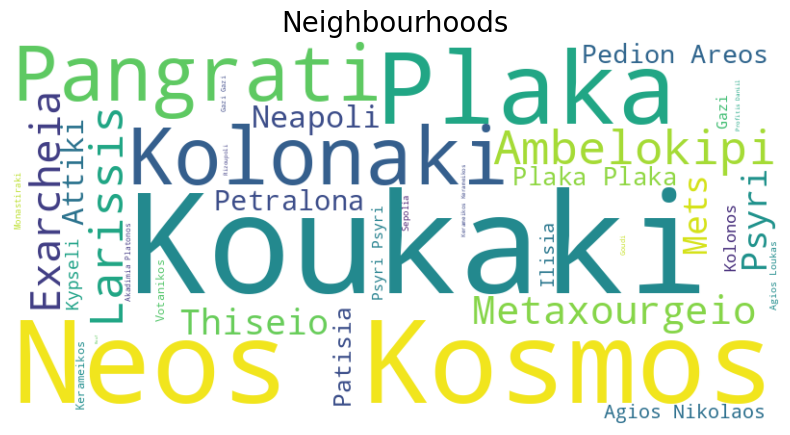

In [55]:
# Drop duplicate IDs
uids_df = df.drop_duplicates(subset=['id'])

neigborhoods = ' '.join(uids_df['neighbourhood'].astype(str))

# Create the wordcloud for neighborhood
neighbwc = WordCloud(prefer_horizontal=0, width=800, height=400, background_color='white').generate(neigborhoods)

plt.figure(figsize=(10, 5))
plt.imshow(neighbwc, interpolation='bilinear')
plt.title('Neighbourhoods', fontsize=20, color='black')
plt.axis('off')
plt.show()

**Transit WC**

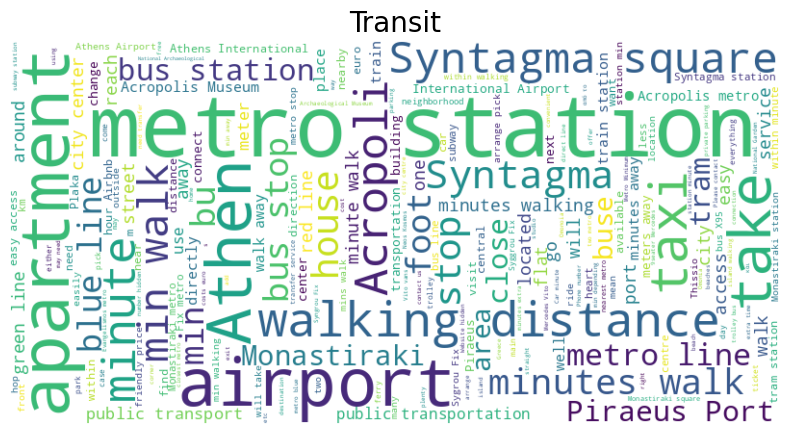

In [56]:
transit = ' '.join(uids_df['transit'].astype(str))

# Create the wordcloud for transit
transwc = WordCloud(prefer_horizontal=0, width=800, height=400, background_color='white').generate(transit)

plt.figure(figsize=(10, 5))
plt.imshow(transwc, interpolation='bilinear')
plt.title('Transit', fontsize=20, color='black')
plt.axis('off')
plt.show()

**Description WC**

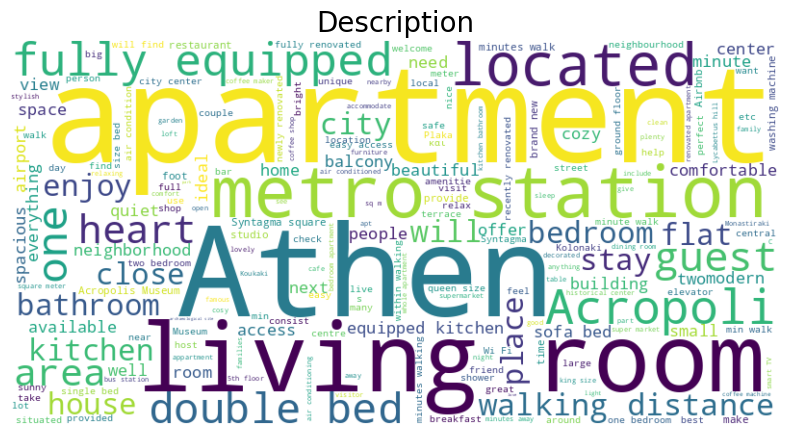

In [57]:
description = ' '.join(uids_df['description'].astype(str))

# Create the wordcloud for description
descriptionwc = WordCloud(width=800, height=400, background_color='white').generate(description)

plt.figure(figsize=(10, 5))
plt.imshow(descriptionwc, interpolation='bilinear')
plt.title('Description', fontsize=20, color='black')
plt.axis('off')
plt.show()

**Comments WC**

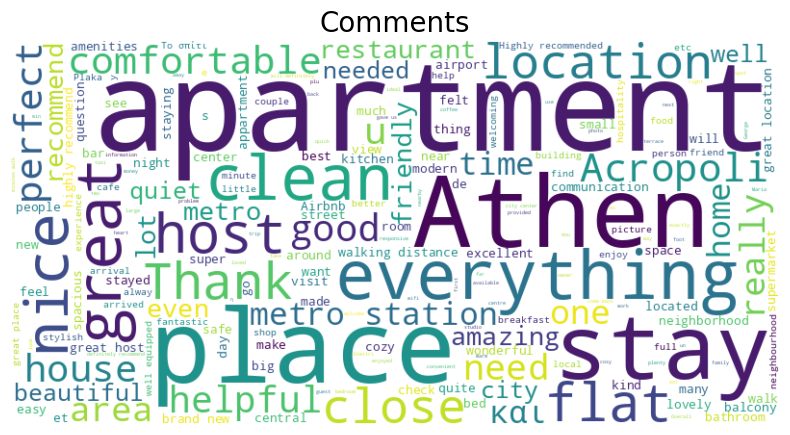

In [58]:
comments = ' '.join(uids_df['comments'].astype(str))

# Create the wordcloud for comments
commentswc = WordCloud(width=800, height=400, background_color='white').generate(comments)

plt.figure(figsize=(10, 5))
plt.imshow(commentswc, interpolation='bilinear')
plt.title('Comments', fontsize=20, color='black')
plt.axis('off')
plt.show()

#### **1.11** ####
 **Amenities - απλοποίηση πληροφορίας**

Εκτύπωση μοναδικών τιμών

In [59]:
uniqueAm = df['amenities'].unique()

uniqueAm

array(['{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Elevator,"Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,Dryer,"First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Hot water","Bed linens","Extra pillows and blankets","Ethernet connection",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,Stove,"Patio or balcony","Luggage dropoff allowed","Host greets you"}',
       '{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Elevator,"Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,"First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","High chair","Pack ’n Play/travel crib","Hot water","Bed linens","Extra pillows and blankets","Ethernet connection",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics

Δημιουργούμε ένα dictionary με τις πιθανές τιμές και τη κατηγορία που εντάσσονται. Έχουμε ομαδοποιήσει τα δεδομένα σύμφωνα με τις κατηγορίες που προτέινονται στην εκφώνηση.

In [60]:
amenitiesMap = {
    "kitchen": ["Kitchen", "Dishwasher", "Microwave", "Oven", "Stove", "Refrigerator", "Coffee maker", "Cooking basics", "Dishes and silverware", "Dryer", "BBQ", "grill"],
    "accessibility": ["Elevator", "Wide doorway", "Step-free access", "Single level home"],
    "Electricity_and_Technology": ["TV", "Cable TV", "Internet", "Wifi", "Ethernet connection", "WIFI", "Tv", "Ethernet cable", "Ethernet"],
    "facilities": ["Air conditioning", "Heating", "Washer", "Dryer", "First aid kit", "Safety card", "Fire extinguisher", "Essentials", "Shampoo", "24-hour check-in", "Hangers", "Hair dryer", "Iron", "Laptop friendly workspace", "Hot water", "Bed linens", "Extra pillows and blankets"],
    "kids_friendly": ["Family/kid friendly", "High chair", "Pack ’n Play/travel crib"],
    "security": ["Smoke detector", "Carbon monoxide detector", "Lock on bedroom door"],
    "services": ["Private entrance", "Room-darkening shades", "Long term stays allowed", "Handheld shower head", "Well-lit path to entrance", "Host greets you"]
}

Αντικαθιστούμε τις τιμές σε ένα καινούριο dataframe με όνομα **simple_am_df** και το εκτυπώνουμε.

In [61]:
simple_am_df = pd.DataFrame(columns=['amenities_simple'])

for index, row in df.iterrows():
    replaced_categories = set()     # Save the categories to replace one time per value 
    replaced_amenities = []         # Store replacements for the current row 
    for category, values in amenitiesMap.items():
        if any(value in row['amenities'] for value in values):
            if category not in replaced_categories:
                replaced_categories.add(category)
                replaced_amenities.append(category)
    simple_am_df.loc[index] = [', '.join(replaced_amenities)]  # Save to new df 

# Sorting 
simple_am_df['amenities_simple'] = simple_am_df['amenities_simple'].apply(lambda x: ', '.join(sorted(x.split(', '))))

with pd.option_context('display.max_colwidth', None):
    print(simple_am_df)

                                                                                        amenities_simple
0                Electricity_and_Technology, accessibility, facilities, kids_friendly, kitchen, services
1                Electricity_and_Technology, accessibility, facilities, kids_friendly, kitchen, services
2                Electricity_and_Technology, accessibility, facilities, kids_friendly, kitchen, services
3                               Electricity_and_Technology, facilities, kids_friendly, kitchen, services
4      Electricity_and_Technology, accessibility, facilities, kids_friendly, kitchen, security, services
...                                                                                                  ...
12662                           Electricity_and_Technology, accessibility, facilities, kitchen, services
12663                           Electricity_and_Technology, accessibility, facilities, kitchen, services
12664            Electricity_and_Technology, accessibil

Δημιουργούμε το ιστόγραμμα με τις νέες τιμές.

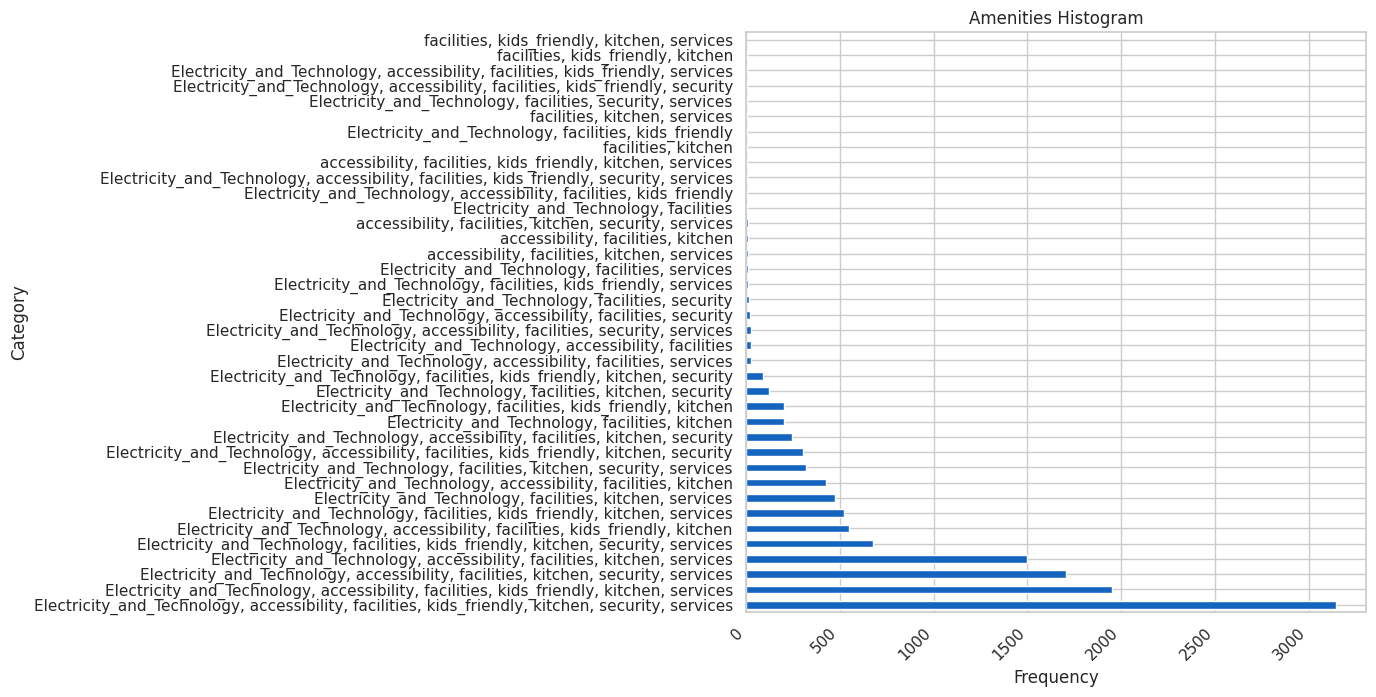

In [62]:
plt.figure(figsize=(8, 10))
simple_am_df['amenities_simple'].value_counts().plot(kind='barh', color='#1565C0')
plt.title('Amenities Histogram')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)  # Increase bottom margin

plt.show()

#### **1.12** ####

**Υπολογισμός μέσης τιμής ανά γειτονία (μόνο για δωμάτια που φιλοξενούν 2 άτομα) και κατάταξη σε 3 ομάδες (πολύ ακριβές, μέτριες, οικονομικές) ανάλογα με την μέση τιμή των δωματίων.**

Αρχικά θα υπολογίσουμε την μέση τιμή ανά γειτονία, θα τις ταξινομήσουμε σε φθίνουσα σειρά και θα εμφανίσουμε το ζητούμενο γράφημα.

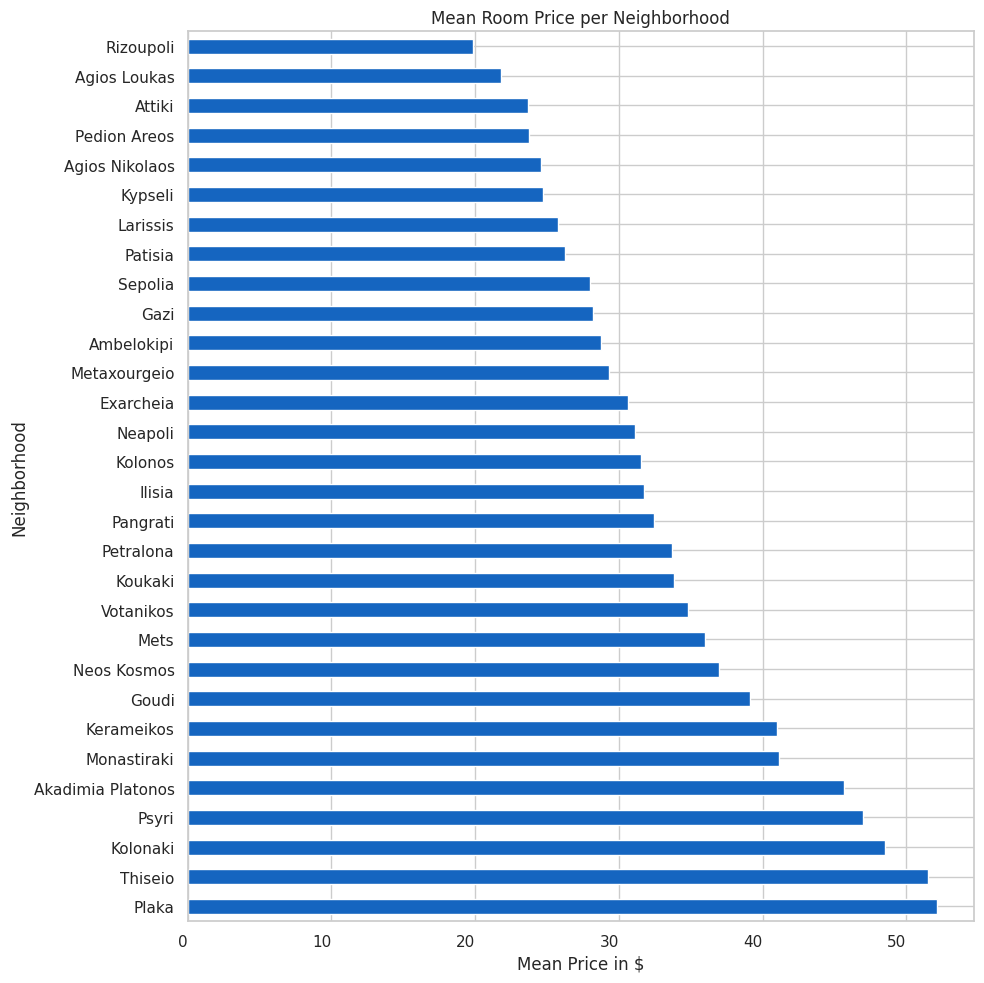

In [63]:
# Calculate the mean price per neighborhood for rooms that accommodate two people
mean_prices = df[df['accommodates'] == 2].groupby('neighbourhood')['price'].mean()

# Sort neighborhoods by their mean price in descending order
mean_prices_sorted = mean_prices.sort_values(ascending=False)

# Display neighborhoods in a bar plot
plt.figure(figsize=(10, 10))
mean_prices_sorted.plot(kind='barh', color='#1565C0')
plt.title('Mean Room Price per Neighborhood')
plt.xlabel('Mean Price in $')
plt.ylabel('Neighborhood')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

Στη συνέχεια θα κατατάξουμε τις περιοχές σε 3 κατηγορίες (πολύ ακριβές, μέτριες, οικονομικές) ανάλογα με την μέση τιμή των δωματίων και θα φτιάξουμε γράφημα για την κάθε κατηγορία.

In [64]:
price_bins = pd.cut(mean_prices,bins=[0, 30, 45, float('inf')], labels=['Οικονομικές', 'Μέτριες', 'Πολύ Ακριβές'])

# Create three separate DataFrames for each category
economy_neighborhoods = mean_prices[price_bins == 'Οικονομικές']
ok_neighborhoods = mean_prices[price_bins == 'Μέτριες']
expensive_neighborhoods = mean_prices[price_bins == 'Πολύ Ακριβές']

Γράφημα για τις 'Οικονομικές' περιοχές:

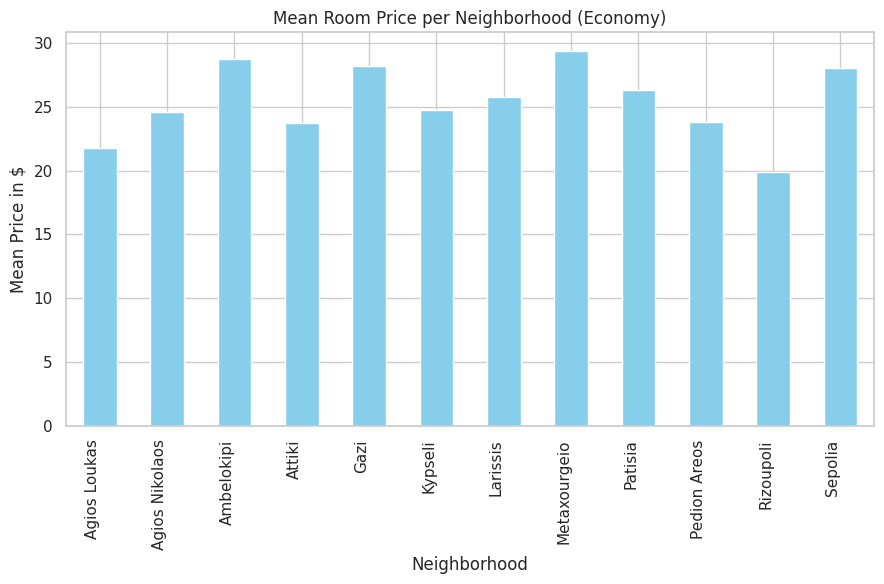

In [65]:
plt.figure(figsize=(9, 6))
economy_neighborhoods.plot(kind='bar', color='skyblue')
plt.title('Mean Room Price per Neighborhood (Economy)')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price in $')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

Γράφημα για τις 'Μέτριες' περιοχές:

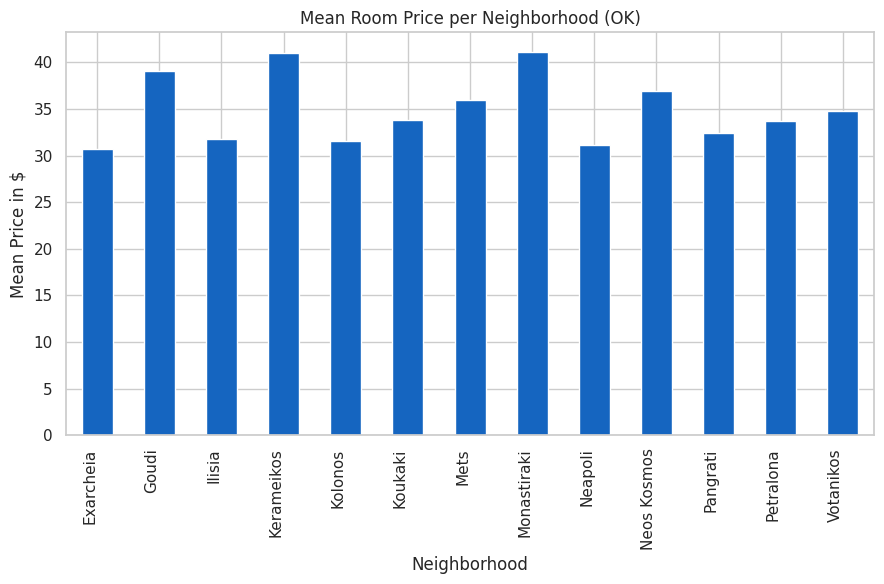

In [66]:
plt.figure(figsize=(9, 6))
ok_neighborhoods.plot(kind='bar', color='#1565C0')
plt.title('Mean Room Price per Neighborhood (OK)')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price in $')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

Γράφημα για τις 'Ακριβές' περιοχές:

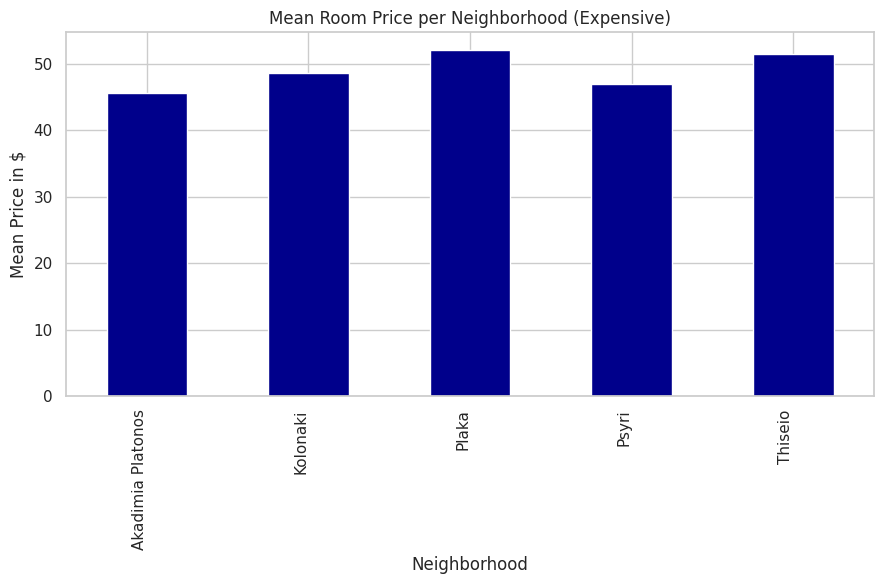

In [67]:
plt.figure(figsize=(9, 6))
expensive_neighborhoods.plot(kind='bar', color='darkblue')
plt.title('Mean Room Price per Neighborhood (Expensive)')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price in $')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

#### **1.13** ####

**Δημιουργία 3 επιπλέον ερωτήσεων για την περιοχή της Αθήνας.**

**1. Ποιό ποσοστό των hosts που έχουν φωτογραφία προφίλ;**

(σε αυτό το ερώτημα θα χρησιμοποιήσουμε pie chart καθώς και την στήλη host_has_profile_pic από το ```train_2019.csv```)

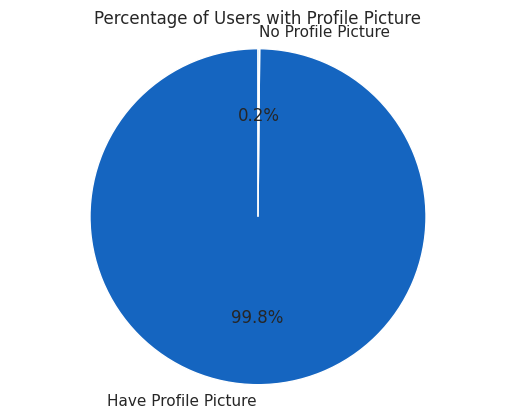

In [68]:
# Count how many times we have the value 't' (true) or 'f' (false) for hosts' profile pics
num_true = df[df['host_has_profile_pic'] == 't'].shape[0]
num_false = df[df['host_has_profile_pic'] == 'f'].shape[0]

# Create a list with the percentages and labels
labels = ['Have Profile Picture', 'No Profile Picture']
sizes = [num_true, num_false]
colors = ['#1565C0','#87CEEB']  

# Create a pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

# Title for the chart
plt.title('Percentage of Users with Profile Picture')

# Show the chart
plt.show()

**2. Ποιό είναι το ποσοστό των κρατήσεων για kids friendly καταλύματα για το έτος 2019;**

Σε αυτό το ερώτημα θα χρησιμοποιήσουμε το απλοποιημένο DataFrame που δημιουργήσαμε στο ερώτημα 1.11 για να βρούμε το ζητούμενο.  
(θα χρησιμοποιήσουμε pie chart για την αναπαράσταση)

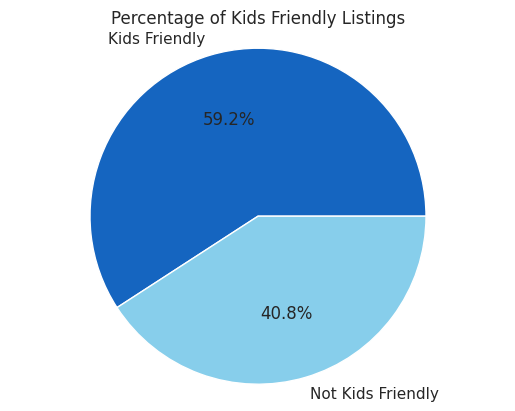

In [69]:
# Count the occurrences of 'kids_friendly' in each row
simple_am_df['has_kids_friendly'] = simple_am_df['amenities_simple'].str.contains('kids_friendly')

# Count the number of rows with and without 'kids_friendly'
kids_friendly_counts = simple_am_df['has_kids_friendly'].value_counts()

# Create a pie chart
labels = ['Kids Friendly', 'Not Kids Friendly']
plt.pie(kids_friendly_counts, labels=labels, autopct='%1.1f%%', colors=['#1565C0','#87CEEB'])
plt.title('Percentage of Kids Friendly Listings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

**3. Ποιός είναι ο πιο συχνός τύπος property_type;**

Εδώ θα αξιοποιήσουμε την στήλη property_type.

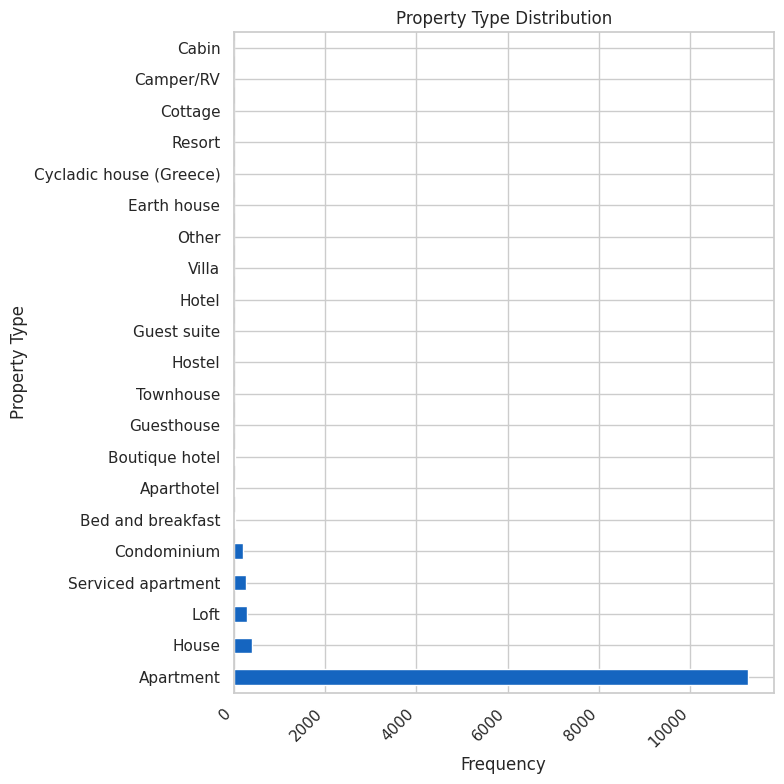

In [70]:
# Count the frequency of each property type
property_type_counts = df['property_type'].value_counts()

# Set the figure size
plt.figure(figsize=(8, 8))

# Create the plot
property_type_counts.plot(kind='barh', color='#1565C0')
plt.title('Property Type Distribution')
plt.xlabel('Frequency')
plt.ylabel('Property Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()                  # Adjust layout to fit better 
plt.show()

Εδώ φαίνεται ότι ο πιο συχνός τύπος property type είναι ο Apartment.

#### **1.14** ####

**Οι 10 πρώτοι hosts με τα περισσότερα ακίνητα.**

In [71]:
# Create a new df with the columns id and host_id
unique_listingsdf = df[['id', 'host_id']]

# Keep unique combinations of host_id and id 
unique_listingsdf = unique_listingsdf.drop_duplicates(subset=['host_id', 'id'])

# Group by host_id and count the number of listings 
host_listingsdf = unique_listingsdf.groupby('host_id').size().reset_index(name='hlistings_count')

# Sort in descending order by hlistings
host_listingsdf = host_listingsdf.sort_values(by='hlistings_count', ascending=False)

# Create the new df
host_listings_count = host_listingsdf[['host_id', 'hlistings_count']]

# We want the first ten
host_listings_count.head(10)

host_id  hlistings_count
742    29927830               85
81      1621474               56
1735  112527018               51
69      1418201               36
94      2089542               32
551    20104194               29
1271   65714690               29
1146   55670751               28
116     2718115               25
2179  159175631               25

#### **1.15** ####
**Συμπεράσματα μετά την ανάλυση των δεδομένων**

Όσον αφορά τις διαφορές ανάμεσα στα δύο έτη παρατηρούμε τα εξής:

Οι γειτονιές φαίνεται να είναι αρκετά περισσότερες το έτος 2023 σε σχέση με το έτος 2019. Αυτό φαίνεται στο ερώτημα 1.12 αλλά και στο ερώτημα 1.5. Επομένως ο αριθμός των καταχωρήσεων έχει αυξηθεί και αυτός. Αυτό παρατηρείται και στο ερώτημα 1.14 όπου φαίνεται πως τα νούμερα των καταλυμάτων για τους 10 πρώτους hosts σε καταχωρήσεις είναι μεγαλύτερα το έτος 2023 σε σχέση με το έτος 2019.  

Σχετικά με τις τιμές, για τον μόνο μήνα που έχουμε κοινό (Μάρτιος), παρατηρούμε πως ο μέσος όρος των τιμών είναι αυξημένος το έτος 2023 σε σχέση με το 2019. Για το 2023 είναι κοντά στο 77 ενώ για το 2019 είναι λίγο πάνω από 48. Οι υψηλότερες τιμές παρατηρούνται τον μήνα Ιούνιο για το έτος 2023.  
Ακόμη φαίνεται πως και για τα 2 έτη δεν αλλάζουν κατα πολύ οι ακριβότερες περιοχές. Περιοχές όπως η Πλάκα, το Θησείο, το Κολωνάκι είναι οι ακριβότερες επιλογές και για τα 2 έτη. Αντίστοιχα, περιοχές όπως η η Κυψέλη, η πλατεία Αττικής, τα Πατήσια φαίνεται να ήταν οι λιγότερο ακριβές περιοχές και για τα 2 έτη.  
Τέλος, παρατηρούμε κάποιες περιοχές όπως το Γκάζι ή τα Ιλίσια να έχουν μια μεγάλη άνοδο στην τιμή το έτος 2023.

> ## Μέρος Β ##

### Ερώτημα 2ο: Recommendation System ###

Κρατάμε μονο τις στήλες που χρειαζόμαστε (id, name, description) από το αρχείο ```train_2019.csv``` τις οποίες θα χρησιμοποιήσουμε στο Recommendation System.  
(θα φτιάξουμε Recommendation System μόνο για τα δεδομένα του έτους 2019)

Το τελικό μας DataFrame θα έχει την μορφή:  
id | (name+description)

(δηλαδή μια στήλη για το id και μία στήλη με το name και το description ενωμένα)

In [72]:
# Read only the columns we want (id, name, description)
cols = ['id','name','description']

# Read the file for 2019
df_19 = pd.read_csv('train_2019.csv',usecols=cols)

Κατεβάζουμε τα stopwords με τη βοήθεια της βιβλιοθήλης nltk

In [73]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/christina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/christina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ορίζουμε τη συνάρτηση remove_stopwords που δέχεται μία πρόταση και την επιστρέφει χωρίς stop words. Χρησιμοποιούμε τη βιβλιοθήκη nltk.

In [74]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    new_token = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(new_token)

Ορίζουμε την συνάρτηση remove_emojis η οποία επιστρέφει μια πρόταση χωρίς emojis.

In [75]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" 
                               u"\U0001F300-\U0001F5FF" 
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f" 
                               u"\u2764"  # heart
                               u"\u2B50"  # star
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

Ορίζουμε μία συνάρτηση για να αφαιρέσουμε τα κόμματα και οποιδήποτε άλλο σύμβολο.

In [76]:
def remove_symbols(text):

    # Replace commas and other symbols with an empty string
    cleaned_text = text.replace(',', '').replace('.', '').replace('>','').replace('-','').replace('<','').replace('!','').replace('?','').replace('`','').replace('"', '').replace(':', '').replace('#', '').replace('+', '').replace("/", '')
    return cleaned_text

Αφαιρούμε τα emoji από την στήλη description

In [77]:
df_19['description'] = df_19['description'].apply(remove_emojis)

Αφαιρούμε τα σύμβολα από την στήλη description

In [78]:
df_19['description'] = df_19['description'].apply(remove_symbols)

Αφαιρούμε τα stop_words από την στήλη description

In [79]:
df_19.loc[:, 'description'] = df_19['description'].apply(remove_stopwords)

with pd.option_context('display.max_colwidth', None):
    print(df_19['description'])

0                                                                                                                                                                       Athens Furnished Apartment No6 3bedroom apartment 2bathrooms excellent located close metro station lovely clean facilities need nice balcony excellent WiFi cable tv fully air conditioned… Athens Furnished Apartment No6 excellent located close metro lovely clean 3bedroom apartment 2bathrooms facilities need balcony 2nd floor worry elevator building Fully equipped kitchen everything need prepare lunchdinner Living room relax enjoy movie sport event 2 Clean nice bathrooms 6 people sofabed Apartment No6 everything need 1st Bedroom – Double bed 2nd Bedroom – 2 single beds 3rd Bedroom – 2 single beds Telephone line incoming calls call us need something Free fast WiFi best internet provider Greece share con
1                                                                                                                         

Αντικαθιστούμε όπου υπάρχει NaN με την λέξη NULL.

In [80]:
# Replace NaN values with 'NULL'
df_19.fillna('NULL', inplace=True)

Δημιουργούμε ένα WordCloud από τη στήλη description χωρίς τα stopwords για να εντοπίσουμε τις πιο χαρακτηριστικές λέξεις.

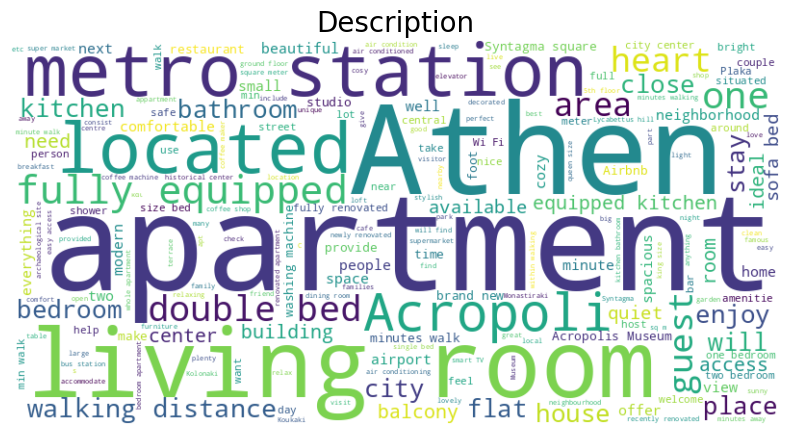

In [81]:
description = ' '.join(uids_df['description'].astype(str))

# Create the wordcloud for description
descriptionwc = WordCloud(width=800, height=400, background_color='white').generate(description)

plt.figure(figsize=(10, 5))
plt.imshow(descriptionwc, interpolation='bilinear')
plt.title('Description', fontsize=20, color='black')
plt.axis('off')
plt.show()

Ενώνουμε τις στείλες name/description σε μια κοινή με όνομα name_desc

In [82]:
df_19['name_desc'] = df_19['name'] + ' ' + df_19['description']

Κρατάμε μόνο τα διαφορετικά id έτσι ώστε να μην μετρήσουμε κάποιο κατάλυμα παραπάνω φορές για διαφορετικό μήνα

In [83]:
df_19.drop_duplicates(subset=['id'], keep='first', inplace=True)
df_19.reset_index()

index        id                                              name  \
0         0     10595               96m2, 3BR, 2BA, Metro, WI-FI etc...   
1         1     10988                75m2, 2-br, metro, wi-fi, cable TV   
2         2     10990                 50m2, Metro, WI-FI, cableTV, more   
3         3     10993               Studio, metro, cable tv, wi-fi, etc   
4         4     10995               47m2, close to metro,cable TV,wi-fi   
...     ...       ...                                               ...   
4837  12662  33551638                  Beautiful apartment in Acropolis   
4838  12663  33581524      Comfortable, spacious studio flat @ Kolonaki   
4839  12664  33595046              Modern Elegant Apartment at Kolonaki   
4840  12665  33608367                               Acropolis Mini Loft   
4841  12666  33628045  Your Beloved Flat in Plaka, close to everything!   

                                            description  \
0     Athens Furnished Apartment No6 3bedroom apartm...   
1     Athens Furnished Apartment No4 2bedroom apartm...   
2     Athens Furnished Apartment No3 1bedroom apartm...   
3     Studio excellent located close metro station l...   
4     AQA No2 1bedroom apartment ( 47m2 ) excellent ...   
...                                                 ...   
4837  beautiful sweet apartment Koukaki quiet safe n...   
4838  Comfortable spacious studio flat 75 sqm situat...   
4839  Often hotels apartments end neglecting privacy...   
4840  Located Acropolis area Koukaki neighborhood Ac...   
4841  brandnew chic decorated studio place short sta...   

                                              name_desc  
0     96m2, 3BR, 2BA, Metro, WI-FI etc... Athens Fur...  
1     75m2, 2-br, metro, wi-fi, cable TV Athens Furn...  
2     50m2, Metro, WI-FI, cableTV, more Athens Furni...  
3     Studio, metro, cable tv, wi-fi, etc Studio exc...  
4     47m2, close to metro,cable TV,wi-fi AQA No2 1b...  
...                                                 ...  
4837  Beautiful apartment in Acropolis beautiful swe...  
4838  Comfortable, spacious studio flat @ Kolonaki C...  
4839  Modern Elegant Apartment at Kolonaki Often hot...  
4840  Acropolis Mini Loft Located Acropolis area Kou...  
4841  Your Beloved Flat in Plaka, close to everythin...  

[4842 rows x 5 columns]

1. **TF-IDF** πίνακας.

In [84]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

# Fit the TfidfVectorizer to the text data and transform it into a TF-IDF matrix
tfidf = tfidf_vec.fit_transform(df_19.name_desc)

print(tfidf.toarray())
print(tfidf.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4842, 188046)


Βλέπουμε ότι έχουμε 4842 γραμμές και 186981 unigrams/bigrams.

2. **Cosine similarity**

In [85]:
# Compute the cosine similarity between TF-IDF vectors
cos_similarities = cosine_similarity(tfidf,tfidf)

# Create a copy for further processing 
final_similarities = cos_similarities.copy()

print(final_similarities)

[[1.         0.454627   0.49457462 ... 0.0150532  0.0167174  0.00569464]
 [0.454627   1.         0.54051012 ... 0.01738944 0.01933879 0.00331153]
 [0.49457462 0.54051012 1.         ... 0.016857   0.02242086 0.00366124]
 ...
 [0.0150532  0.01738944 0.016857   ... 1.         0.02747499 0.01048643]
 [0.0167174  0.01933879 0.02242086 ... 0.02747499 1.         0.01241809]
 [0.00569464 0.00331153 0.00366124 ... 0.01048643 0.01241809 1.        ]]


Προκειμένου να μην συγκρίνουμε κάποιο κατάλυμα με τον εαυτό του, γεμίζουμε τη διαγώνιο στον πίνακά μας με 0.
Επίσης, ο πίνακας είναι συμμετρικός ως προς τη κύρια διαγώνιο, οπότε μπορούμε να αγνοήσουμε τα στοιχεία πάνω απο τη κύρια διαγώνιο.

In [86]:
# Fill the diagonal elements of the matrix with zeros
np.fill_diagonal(final_similarities, 0.0)

# Get the lower triangular matrix
lower_triangular = np.tri(*final_similarities.shape)

# Multiply each element of the matrix by the corresponding element of the lower triangular matrix
final_similarities = final_similarities * lower_triangular

print(final_similarities)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.454627   0.         0.         ... 0.         0.         0.        ]
 [0.49457462 0.54051012 0.         ... 0.         0.         0.        ]
 ...
 [0.0150532  0.01738944 0.016857   ... 0.         0.         0.        ]
 [0.0167174  0.01933879 0.02242086 ... 0.02747499 0.         0.        ]
 [0.00569464 0.00331153 0.00366124 ... 0.01048643 0.01241809 0.        ]]


Τέλος, βρίσκουμε τα 100 πιο όμοια ακίνητα και τα αποθηκεύουμε σε ενα dictionary.

In [87]:
N = 100

# Get indices of top N similar pairs
idx = np.argpartition(final_similarities.ravel(), -N)[-N:]
topN_val = final_similarities.ravel()[idx]
topN_val_indices = np.unravel_index(idx, final_similarities.shape)

# Store top N similar pairs in a dictionary
topN_pairs = {}
for i in range(N):
    x, y = topN_val_indices[0][i], topN_val_indices[1][i]
    topN_pairs[(x, y)] = topN_val[i]

# Sort the top N similar pairs by similarity in descending order based on similarity value 
sorted_topN_pairs = sorted(topN_pairs.items(), key=lambda item: item[1], reverse=True)

# Print 
print("Top 100 most similar listings :\n")
for (x, y), similarity in sorted_topN_pairs:
    print("Id: {} - Id: {} - Similarity: {:.2f}".format(df_19.iloc[x]['id'], df_19.iloc[y]['id'], similarity))

Top 100 most similar listings :

Id: 30906405 - Id: 30341020 - Similarity: 1.00
Id: 30980429 - Id: 30760835 - Similarity: 1.00
Id: 30089884 - Id: 30980510 - Similarity: 1.00
Id: 30906405 - Id: 30362269 - Similarity: 1.00
Id: 30980429 - Id: 30906405 - Similarity: 1.00
Id: 30089884 - Id: 30980429 - Similarity: 1.00
Id: 30089884 - Id: 30906405 - Similarity: 1.00
Id: 30906405 - Id: 30363015 - Similarity: 1.00
Id: 30362269 - Id: 30341020 - Similarity: 1.00
Id: 30089884 - Id: 30760835 - Similarity: 1.00
Id: 30906405 - Id: 30760835 - Similarity: 1.00
Id: 30760835 - Id: 30363015 - Similarity: 1.00
Id: 30760835 - Id: 30362269 - Similarity: 1.00
Id: 30760835 - Id: 30341020 - Similarity: 1.00
Id: 30089884 - Id: 30363015 - Similarity: 1.00
Id: 30089884 - Id: 30362269 - Similarity: 1.00
Id: 30089884 - Id: 30341020 - Similarity: 1.00
Id: 30980510 - Id: 30341020 - Similarity: 1.00
Id: 30980510 - Id: 30362269 - Similarity: 1.00
Id: 30980510 - Id: 30363015 - Similarity: 1.00
Id: 30980510 - Id: 30760835

3. **Prediction**

Θα δημιουργήσουμε μία συνάρτηση η οποία θα παίρνει σαν είσοδο ένα id και έναν ακέραιο αριθμό num, και επιστρέφει τα Ν πιο όμοια ακίνητα.

In [88]:
def recommendation_system(item_id, num):

    # Find the index of the product in the dataframe
    idx = df_19.index[df_19['id'] == item_id].tolist()

    if not idx:
        print("Given ID not found.")
        return
    
    idx = idx[0]

    # Get similarity scores of the product with all other products
    sim_scores = list(enumerate(final_similarities[idx]))

    # Sort the products based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of top similar products
    top_indices = [i[0] for i in sim_scores[1:num+1]]

    # Print results
    print('-> Recommending {} listings similar to "{}":\n'.format(num, df_19.iloc[idx]['name']))

    for i in range(len(top_indices)):

        print('Recommended: {}\n'.format(df_19.iloc[top_indices[i]]['name']))
        print('Description: "{}"'.format(df_19.iloc[top_indices[i]]['description']))
        print('(score: {:.2f})'.format(sim_scores[i][1]))
        print('----------------------------------------------------------------------------')

Εδώ θα δοκιμάσουμε το Recommendation System για 5 όμοια ακίνητα με το δωσμένο id.

In [89]:
recommendation_system(26092250, 5) 

-> Recommending 5 listings similar to "1. Acropolis Museum Apartment.":

Recommended: 3. Acropolis Museum Apartment

Description: "Welcome new home Athens find entire floor separated 5 private apartments brand new minimal decoration nothing distinguish luxury hotel Enjoy unforgettable sleep COCOMAT bed Check could easier access allowed locker system code needs entered Located breath away Acropolis museum one touristic locations Athens everything walkable distance enjoy amazing Acropolis view rooftop upon request modern spacious flat Koukaki area central Athens accommodate 4The apartment features unique minimal style super comfortable beds feature selection COCOMAT ’ finest natural mattresses Spacious bathrooms feature customdesigned marble tops glass shower stalls rooms furnished wardrobes comfortable sofa used bed well 500 meters Acrop"
(score: 0.98)
----------------------------------------------------------------------------
Recommended: 4.Acropolis Museum Apartment.

Description: "W

4. **Top 10 λέξεις που τείνουν να εμφανίζονται μαζί**

In [90]:
# Create an instance of BigramAssocMeasures for association measures
bigram_m = BigramAssocMeasures()

# Create the BigramCollocationFinder object from the 'description' column 
finder = BigramCollocationFinder.from_words(' '.join(list(df_19['description'])).split())

# Find the top 10 collocations 
top10col = finder.nbest(BigramAssocMeasures.pmi, 10)

print("Top-10 collocations: \n")
for pair_words in top10col:
    print("{} - {}".format(pair_words[0], pair_words[1]))

Top-10 collocations: 

'M - DESIGNER
'Old - Jewellery
'Plateia - plastira
0600am - 0030am
0730 - Rearrangement
11000700am - Hellο
135m - 2wc
1430 - 1700
15001700 - 11000700am
18000 - BTU


>> **Μάρρας Ηλίας**  
**Διαμαντή Χριστίνα**